In [1]:
import pandas as pd
import numpy as np
import math

from scipy.stats import spearmanr
from scipy.spatial import distance

from sklearn.neighbors import NearestNeighbors
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from yellowbrick.cluster import KElbowVisualizer

import p1_functions

# Set random seed
np.random.seed(43)

/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/

# 1. Loading the Data, Preprocessing, Initial Data Analysis

In [2]:
df = pd.read_csv(r"https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv")
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [3]:
# Correct the typo
df.rename(columns = {'Delicassen':'Delicatessen'}, inplace = True)

#Describe the dataframe
df.describe()

# Number of distinct elements per column
#df.nunique()

# Check for NaNs
#df.isnull().values.any()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


#### Attribute Information:
CHANNEL: customers' Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
REGION: customers' Region - Lisnon, Oporto or Other (Nominal)
FRESH: annual spending (m.u.) on fresh products (Continuous)
MILK: annual spending (m.u.) on milk products (Continuous)
GROCERY: annual spending (m.u.)on grocery products (Continuous)
FROZEN: annual spending (m.u.)on frozen products (Continuous)
DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)

In [4]:
# Get nominal and numerical attributes
dtype = df.dtypes
cat_features = ["Channel", "Region"] #df[["Channel", "Region"]]
num_features = df.drop(columns=["Channel", "Region"]).columns.tolist()

print("Nominal features:", cat_features)
print("Numerical features:", num_features)

Nominal features: ['Channel', 'Region']
Numerical features: ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicatessen']


## 1.1. Basic statistical visualisations of the data

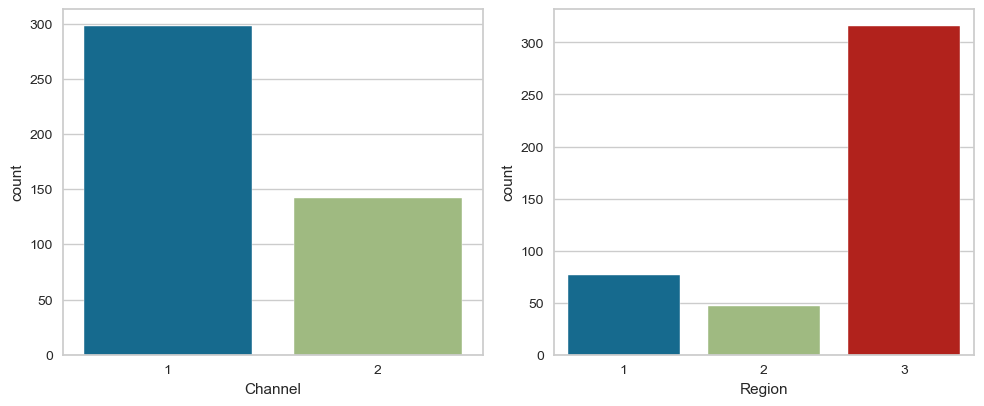

In [5]:
# Plot distributions of attributes: NOMINAL (barplots)
p1_functions.cat_plot(df, cat_features)

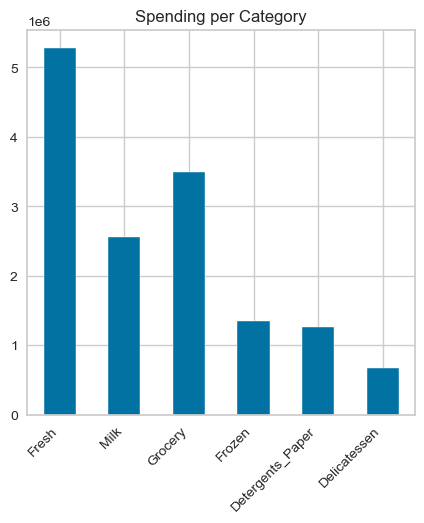

In [6]:
# Plot overall spending per category
fig = plt.figure(figsize=(5,5))
df[num_features].sum().plot.bar()
plt.title("Spending per Category")
plt.xticks(rotation=45, ha='right')
plt.show()

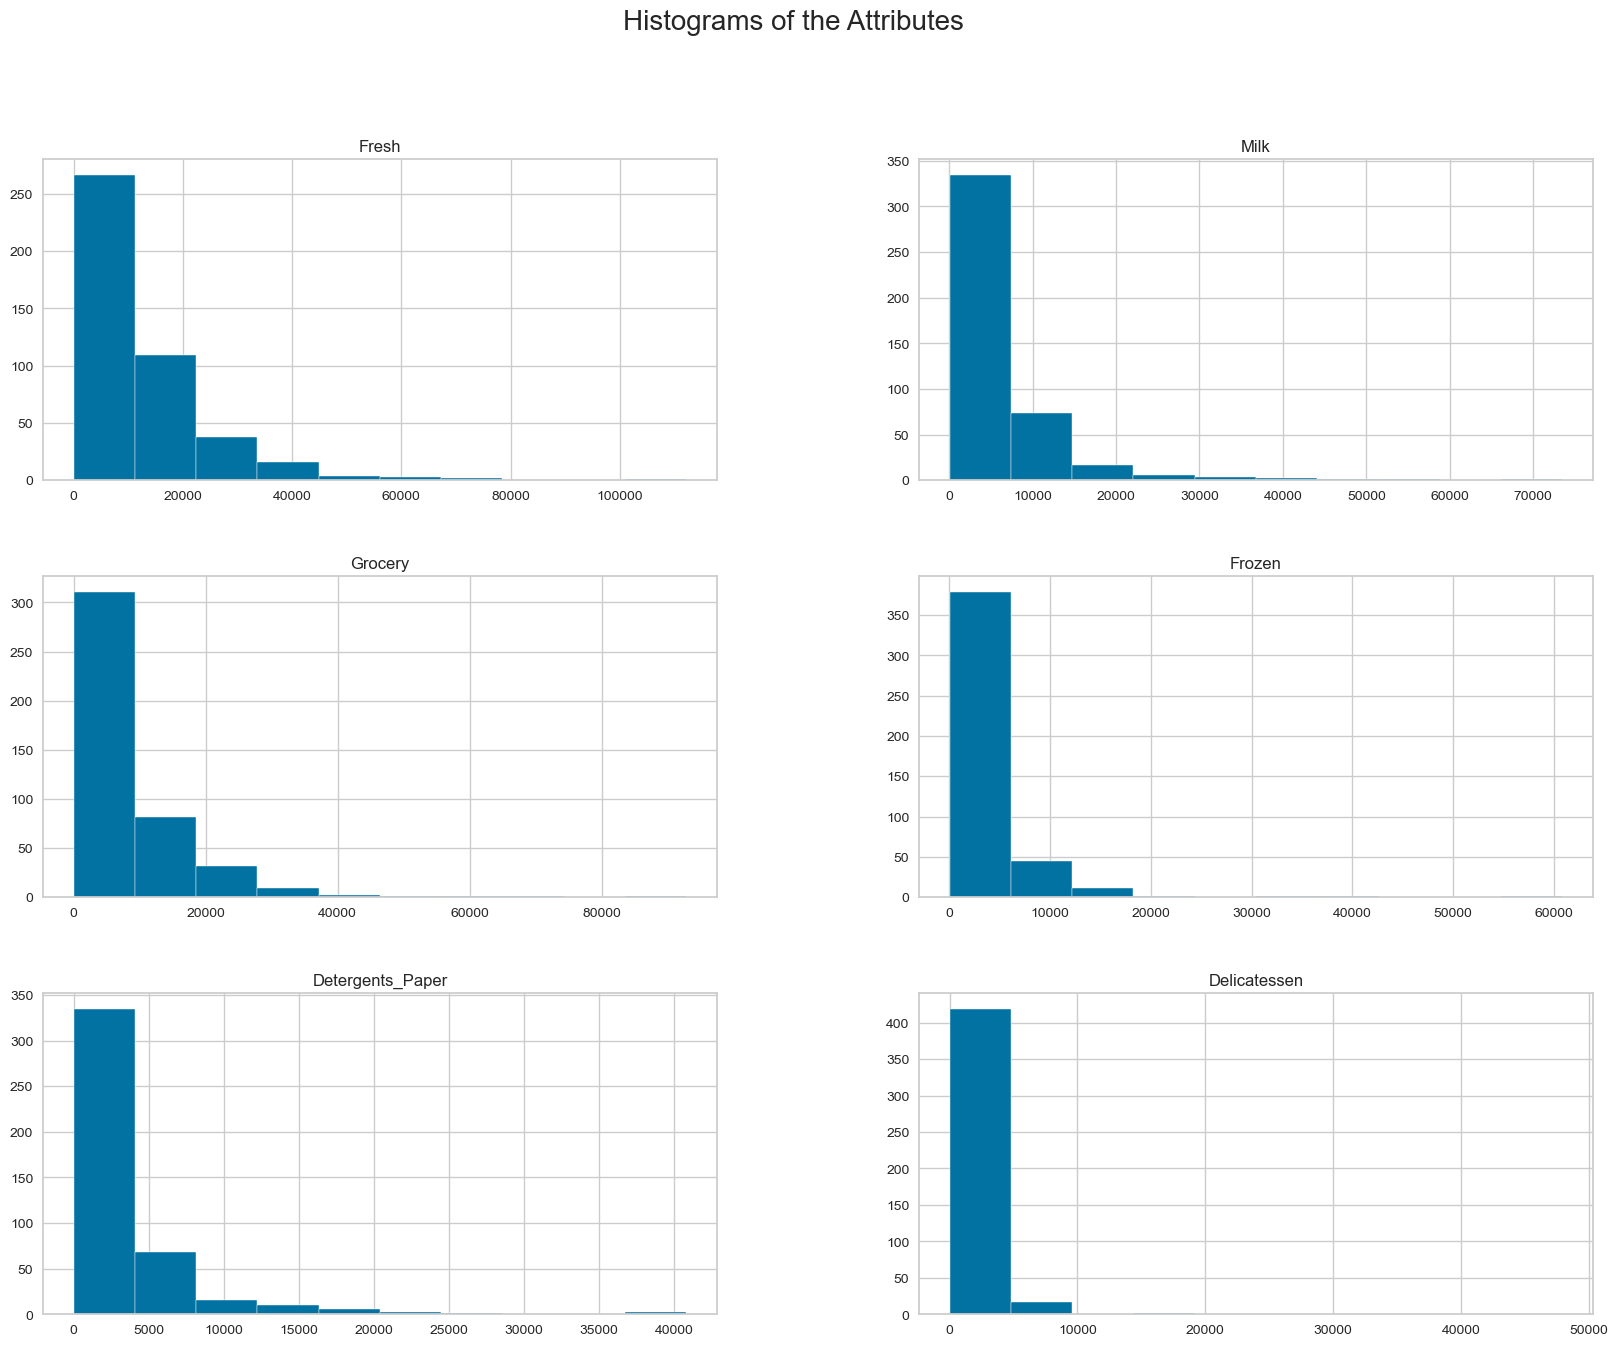

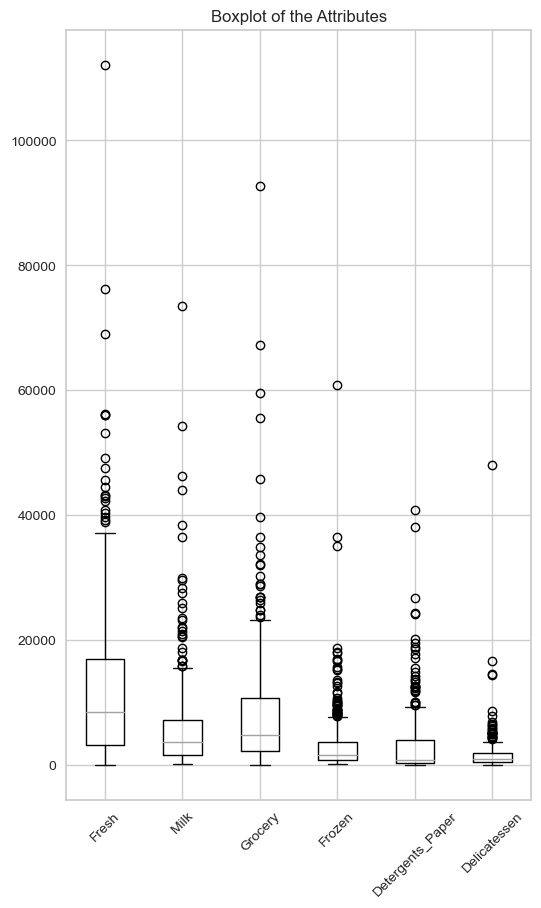

/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


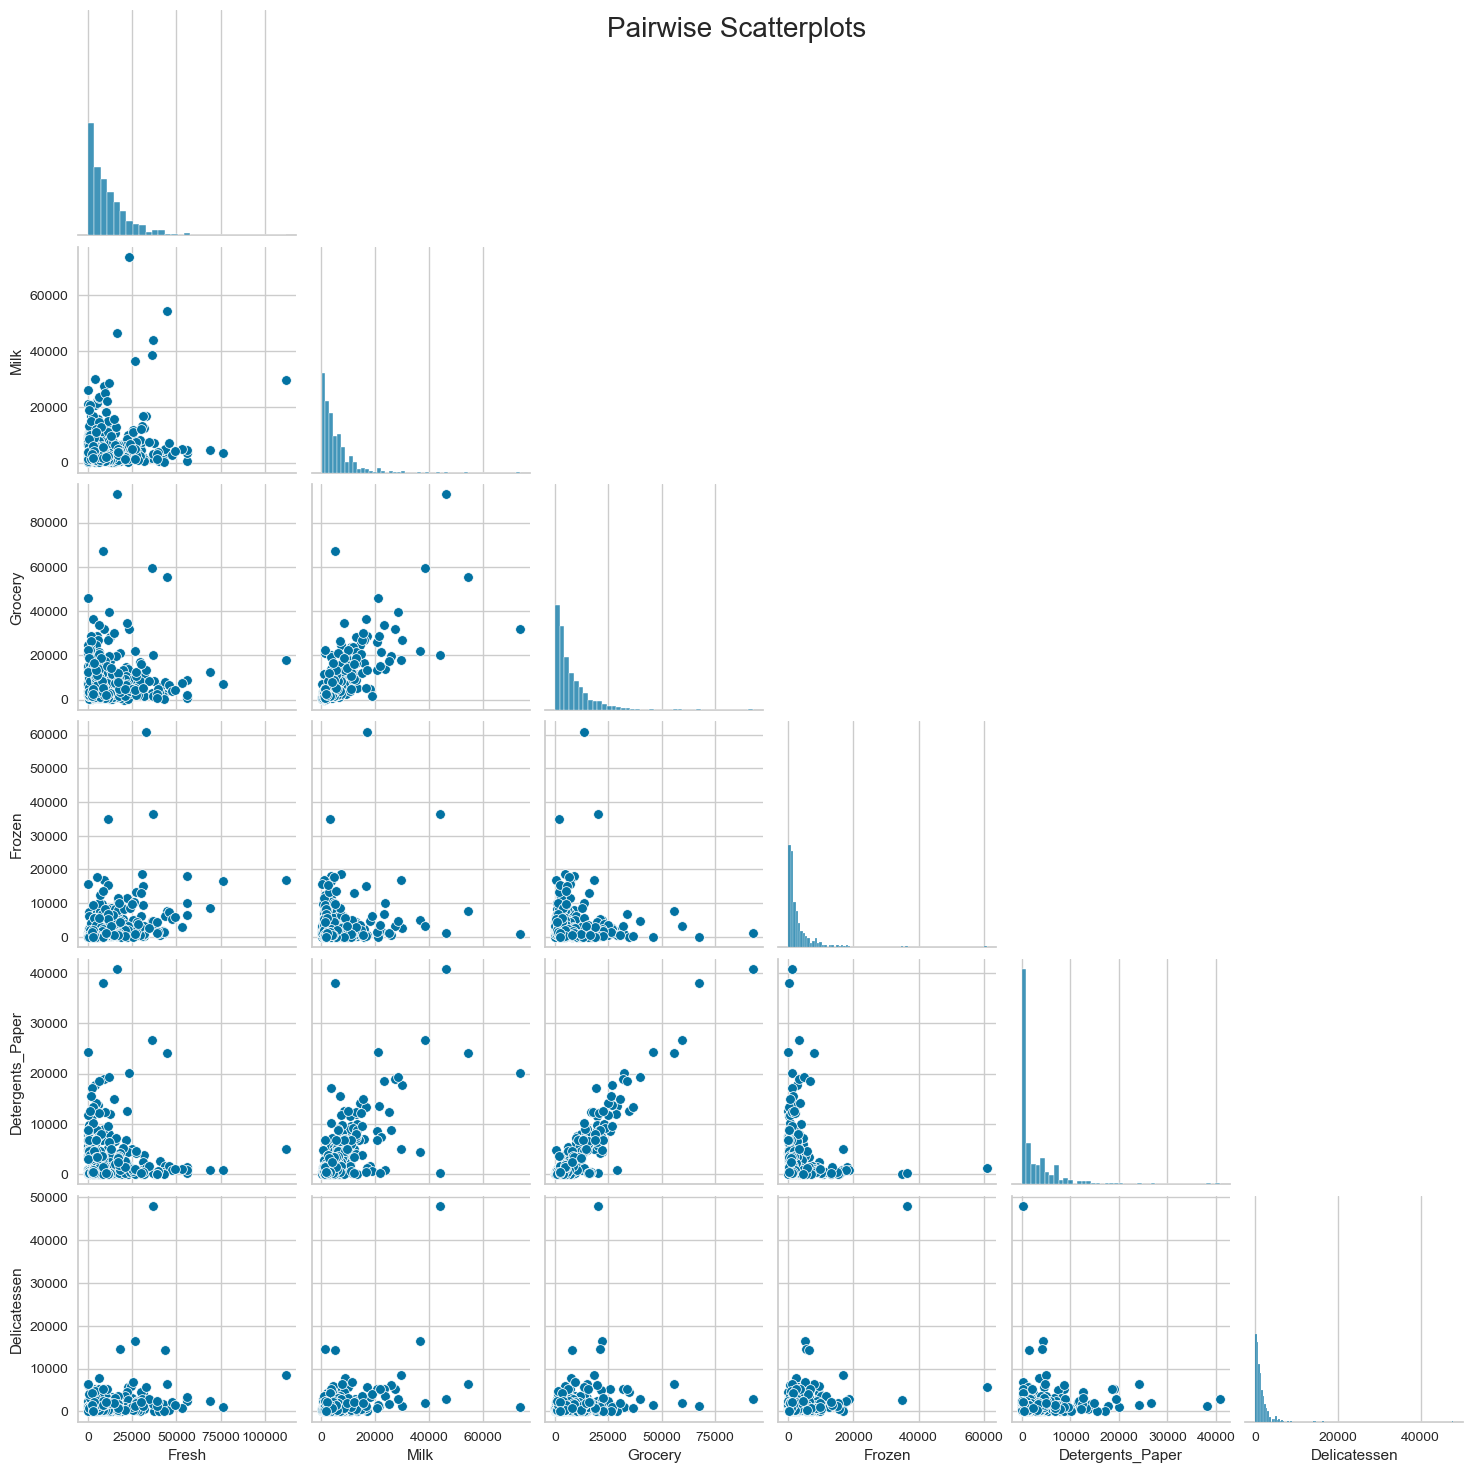

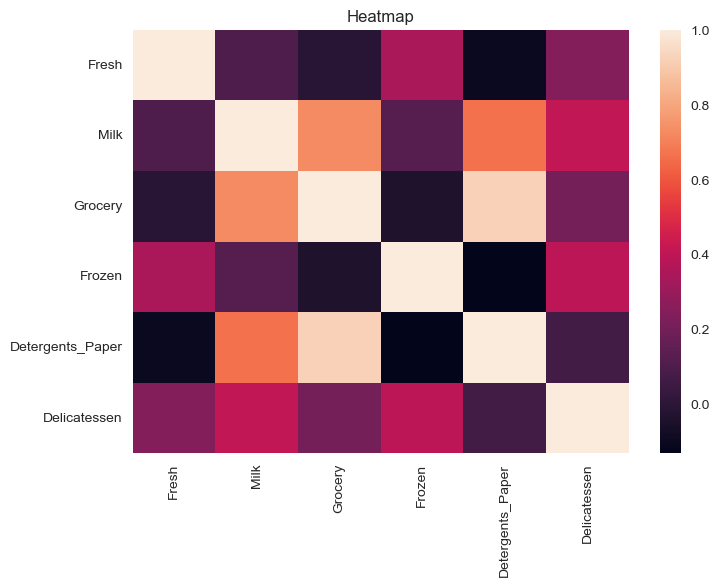

In [7]:
# Plot distributions of attributes: NUMERICAL (histograms, boxplot)
# Plot correlations (pairwise scatterplots and heatmap)
p1_functions.num_plot(df[num_features])

Observation:
The distributions are heavy tailed -> apply the log function to the continuous features so that the distribution becomes compressed for large values and expanded for small values

In [8]:
# Drop meta-data: Channel and the Region indicators
df = df.drop(columns=cat_features)

# Save the original dat set without meta-data
df_og = df.copy() # we will use this to look at the original values
df_overview = df.copy() # we will use this to append the scores for an overview. Calculations are performed on df

# x ← log(x + 1)
df = np.log(df + 1) # we will use this for further analysis

### Recomputed plots

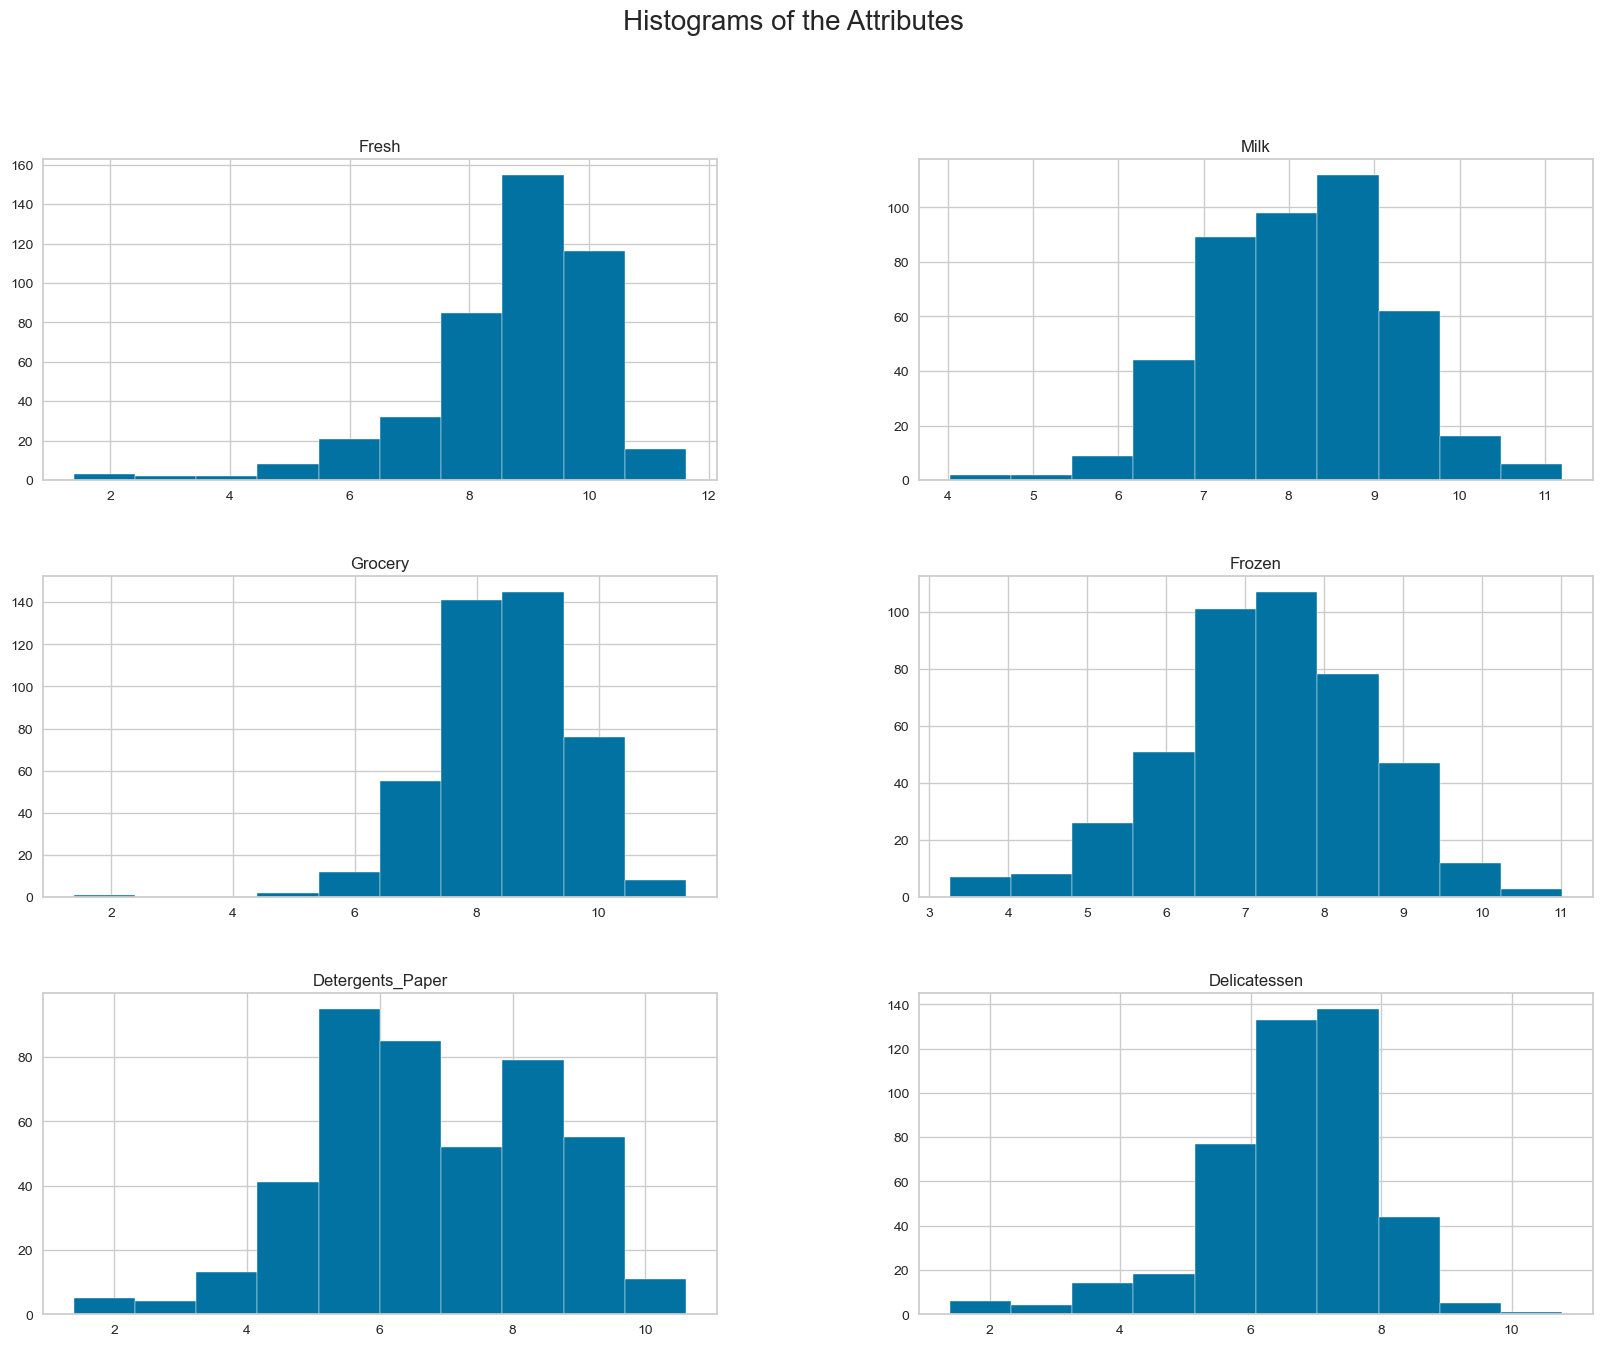

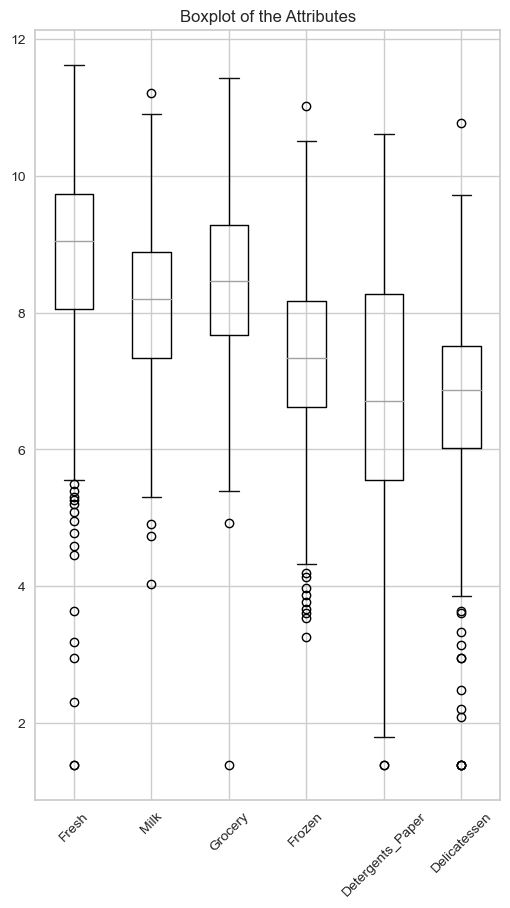

/Users/gabrieleinciuraite/miniconda3/envs/DNN/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


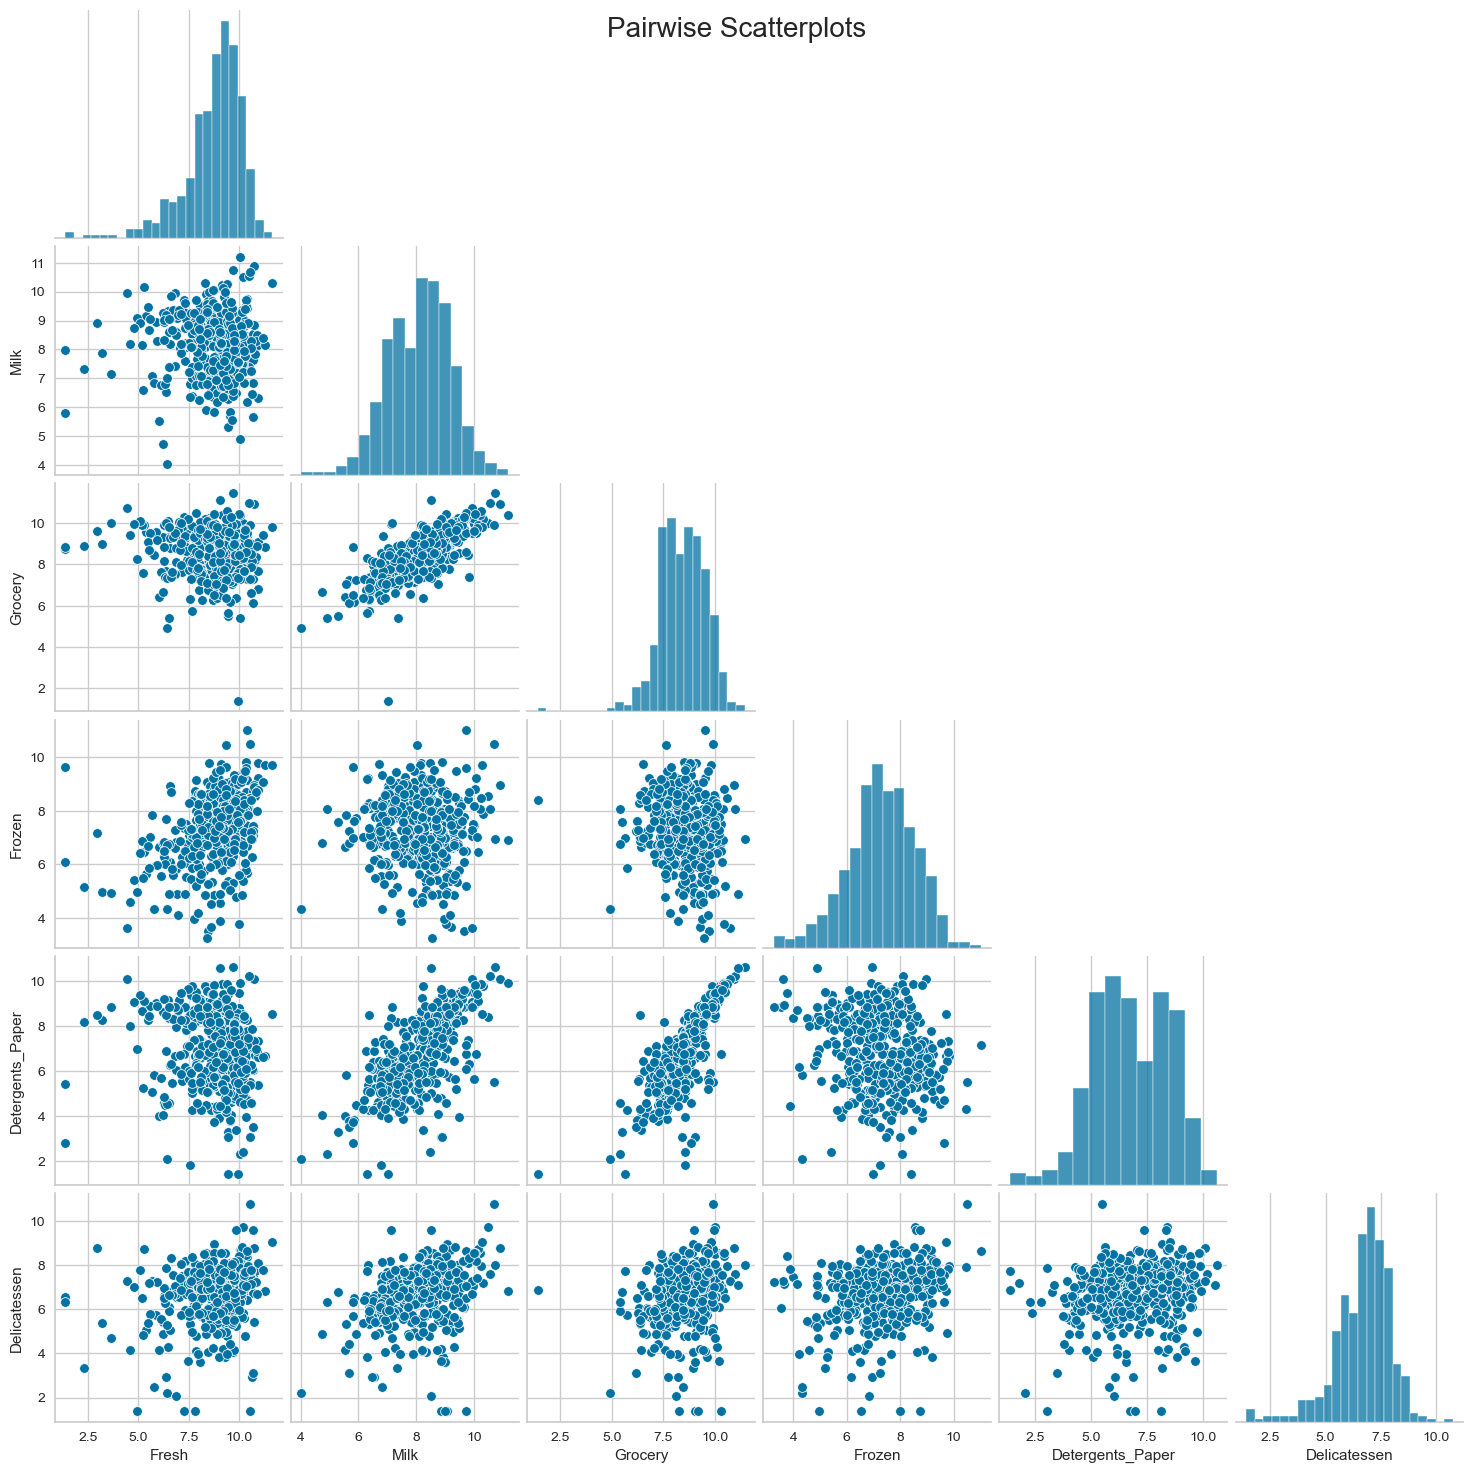

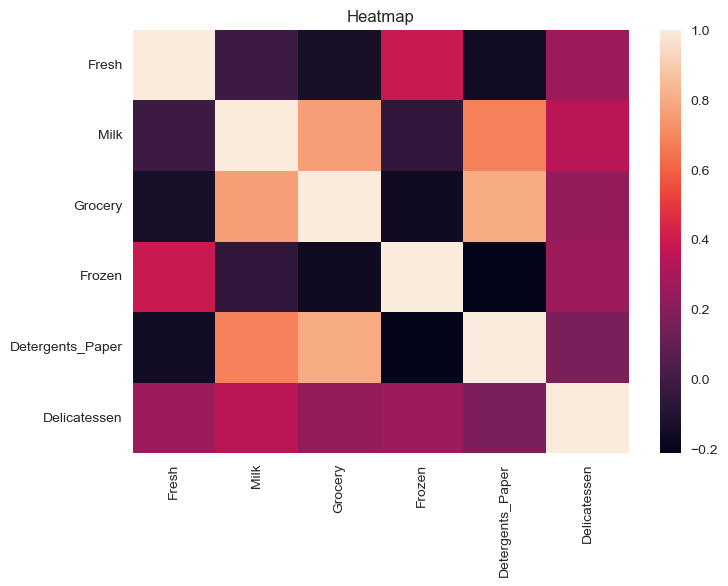

In [9]:
# Recompute plots after the transformation
p1_functions.num_plot(df)

Observation:
The log transformation produces more normally distributed attributes, however the statistics can not be reliably computed (e. g. correlations). Also, some lower values can now be considered extreme, while very few higher values still possess this quality (see boxplots).

# 2. Detecting Anomalies

## 2.1. Hard-Min Score

In [10]:
# Setting the HYPERPARAMETERS
N_BOOTSTRAP = 10000
#SAMPLE_SIZE_FRAC = 0.5
OUTLIERS_FRAC = 0.10 #extreme: 0.111 #0.055 #0.04

In [11]:
def hardmin_score(df):
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(df)
    distances, indices = nbrs.kneighbors(df)
    outlier_score_min = np.square(distances[:, 1])
    return outlier_score_min

In [12]:
df_overview["hardmin_score"] = hardmin_score(df)
df_overview.sort_values(by="hardmin_score", ascending=True).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,hardmin_score
107,8797,10646,14886,2471,8969,1438,0.075394
63,9396,11601,15775,2896,7677,1295,0.075394
158,2861,6570,9618,930,4004,1682,0.099866
197,2427,7097,10391,1127,4314,1468,0.099866
114,18044,1080,2000,2555,118,1266,0.114767
217,18044,1475,2046,2532,130,1158,0.114767
421,17063,4847,9053,1031,3415,1784,0.121436
279,17360,6200,9694,1293,3620,1721,0.121436
163,5531,15726,26870,2367,13726,446,0.124955
349,5981,14641,20521,2005,12218,445,0.124955


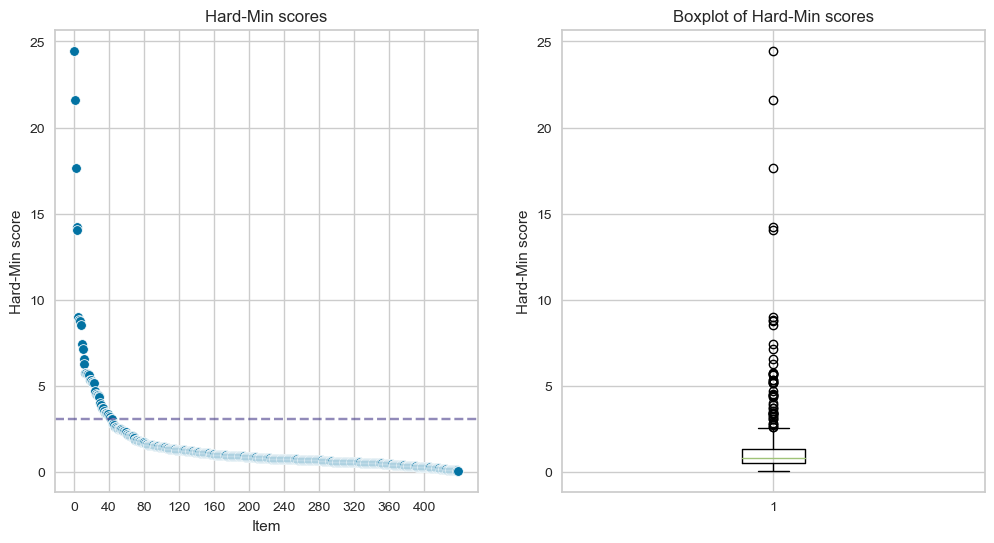

44 outliers above 3.0883540879336224
44 points with highest Hard-Min Scores: 
[338, 75, 154, 142, 95, 187, 128, 183, 204, 109, 218, 65, 228, 161, 402, 184, 203, 439, 285, 66, 145, 233, 137, 177, 333, 71, 174, 289, 190, 141, 181, 325, 429, 138, 253, 430, 412, 23, 131, 275, 358, 185, 270, 88]


In [13]:
# Plot Hard-Min-Score outlier values
outliers_hard = df_overview["hardmin_score"]
outliers_n = int((len(df) * OUTLIERS_FRAC))
outliers_hard_selected = outliers_hard.argsort()[::-1][:outliers_n]
last_outlier = outliers_hard_selected[-1:]
threshold = df_overview.iloc[last_outlier]["hardmin_score"]
threshold = threshold.iloc[0]

outliers_list = df.iloc[outliers_hard_selected,:].index.tolist()
min, max = p1_functions.plot_outliers(outliers_hard, "hardmin", threshold)

#threshold = 5
#mask = outliers_hard > threshold
#outliers_hard_selected = outliers_hard.argsort()[::-1][:sum(mask)]
#outliers_n = outliers_hard_selected.shape[0]
#p1_functions.plot_outliers(outliers_hard, "hardmin", threshold)

# Which points are the biggest outliers
print(outliers_n, "outliers above", str(threshold))
print(f"{outliers_n} points with highest Hard-Min Scores: \n{outliers_list}")

In [14]:
samples = [resample(df, n_samples=(len(df)), replace=True) for i in range(N_BOOTSTRAP)]

In [15]:
def hardmin_bootstrap(samples = samples):
    scores = np.full((len(df), N_BOOTSTRAP), np.nan) # customer x bootstrap round

    for i in range(0, N_BOOTSTRAP):
        sample = samples[i]

        # ver 2) Add Gaussian noise
        #m = 0  # Mean of the Gaussian noise
        #std = 0.1  # Standard deviation of the Gaussian noise
        #noise = np.random.normal(loc=m, scale=std, size=sample.shape)
        #sample = sample + noise
        # Clip values at zero
        #sample = sample.clip(lower=0)

        # ver 3) Calculate mean of rows with duplicate indices
        #print(len(sample))
        #sample = sample.groupby(sample.index).mean()
        #print("++", len(sample))

        #print(np.sum(hardmin_score(sample)==0))
        scores[sample.index, i] = hardmin_score(sample)
    return scores

In [16]:
hardmin_bootstrap_scores = hardmin_bootstrap()
hardmin_bootstrap_scores.shape

(440, 10000)

In [17]:
df_overview["hardmin_bootstrap_score"] = np.nanmean(hardmin_bootstrap_scores, axis=1)
df_overview["hardmin_bootstrap_score_var"] = np.nanvar(hardmin_bootstrap_scores, axis=1)
df_overview.sort_values(by="hardmin_bootstrap_score", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,hardmin_score,hardmin_bootstrap_score,hardmin_bootstrap_score_var
338,3,333,7021,15601,15,550,24.462058,15.719235,211.995912
75,20398,1137,3,4407,3,975,21.598732,13.007076,125.761809
154,622,55,137,75,7,8,17.656426,11.655222,106.174997
95,3,2920,6252,440,223,709,14.033121,9.589521,68.980074
142,37036,7152,8253,2995,20,3,14.249027,9.574669,69.156428
187,2438,8002,9819,6269,3459,3,9.006401,5.749682,23.701770
183,36847,43950,20170,36534,239,47943,8.742070,5.648342,23.384253
128,140,8847,3823,142,1062,3,8.841779,5.456264,21.552514
204,1956,891,5226,1383,5,1328,8.531557,5.112135,18.836317
109,1406,16729,28986,673,836,3,7.406475,4.762219,16.146419


In [18]:
df_overview.sort_values(by="hardmin_bootstrap_score_var", ascending=False).head(10)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,hardmin_score,hardmin_bootstrap_score,hardmin_bootstrap_score_var
338,3,333,7021,15601,15,550,24.462058,15.719235,211.995912
75,20398,1137,3,4407,3,975,21.598732,13.007076,125.761809
154,622,55,137,75,7,8,17.656426,11.655222,106.174997
142,37036,7152,8253,2995,20,3,14.249027,9.574669,69.156428
95,3,2920,6252,440,223,709,14.033121,9.589521,68.980074
187,2438,8002,9819,6269,3459,3,9.006401,5.749682,23.701770
183,36847,43950,20170,36534,239,47943,8.742070,5.648342,23.384253
128,140,8847,3823,142,1062,3,8.841779,5.456264,21.552514
204,1956,891,5226,1383,5,1328,8.531557,5.112135,18.836317
65,85,20959,45828,36,24231,1423,6.589560,4.612836,16.687488


In [19]:
def score_bias_eval(scores, baseline=df_overview["hardmin_bootstrap_score"], outlier_frac=OUTLIERS_FRAC, return_p_val=False):
    n_outliers = math.ceil(len(baseline) * outlier_frac)
    n_outliers_extreme = 5
    # Baseline
    hardmin_bootstrap_ranking = np.argsort(baseline * (-1))
    hardmin_outliers = hardmin_bootstrap_ranking[:n_outliers]
    hardmin_outliers_Extreme = hardmin_bootstrap_ranking[:n_outliers_extreme]
    # Score for comparisson
    score_outlier_ranking = np.argsort(scores * (-1))
    score_outliers = score_outlier_ranking[:n_outliers]
    score_outliers_extreme = score_outlier_ranking[:n_outliers_extreme]

    spr_all = spearmanr(scores, baseline)
    spr_fraction = spearmanr(score_outliers, hardmin_outliers)
    spr_extreme = spearmanr(score_outliers_extreme, hardmin_outliers_Extreme)

    accuracy = len(set(hardmin_outliers).intersection(score_outliers)) / n_outliers

    return accuracy, spr_all[0], spr_fraction[0], spr_extreme[0]

acc, spr_all, spr_fraction, spr_extreme = score_bias_eval(scores=hardmin_score(df))

print(f"Accuracy: {acc:.2}% "
      f"\nSpearman corr.: {spr_all:.2}"
      f"\nSpearman corr. on the fraction of outliers: {spr_fraction:.2}"
      f"\nSpearman corr. on the top five outliers: {spr_extreme:.2}")

Accuracy: 0.95% 
Spearman corr.: 0.97
Spearman corr. on the fraction of outliers: 0.31
Spearman corr. on the top five outliers: 0.9


## 2.2. The Soft-Min Score

In [20]:
def softmin(z, gamma):
    return - (1/gamma)  * np.log(1 / (len(z) - 1) * np.sum(np.exp(-gamma * z)))

In [21]:
gamma_range = np.linspace(0.1, 2, 20)

def softmin_bootstrap(samples = samples):
    scores = np.full((len(df), N_BOOTSTRAP, len(gamma_range)), np.nan) # customer x bootstrap round x gamma
    for i in range(0, N_BOOTSTRAP):
        sample = samples[i]

        # ver 2) Add Gaussian noise
        #m = 0  # Mean of the Gaussian noise
        #std = 0.1  # Standard deviation of the Gaussian noise
        #noise = np.random.normal(loc=m, scale=std, size=sample.shape)
        #sample = sample + noise
        # Clip values at zero
        #sample = sample.clip(lower=0)

        # ver 3) Calculate mean of rows with duplicate indices
        #print(len(sample))
        #sample = sample.groupby(sample.index).mean()
        #print("++", len(sample))

        nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
        distances, indices = nbrs.kneighbors(sample)
        distances = np.square(distances[:, 1:])

        for j, gamma in enumerate(gamma_range):
            #print(np.min(np.apply_along_axis(softmin, 1, distances, gamma)))
            scores[sample.index, i, j] = np.apply_along_axis(softmin, 1, distances, gamma)

    return scores

In [22]:
softmin_bootstrap_scores = softmin_bootstrap()
softmin_bootstrap_scores.shape

(440, 10000, 20)

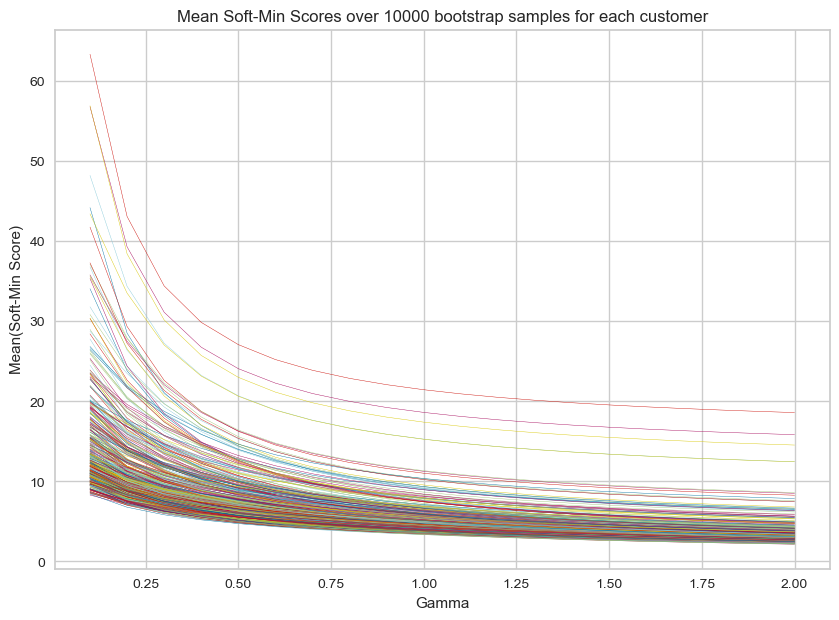

In [23]:
# average outlier score per sample, per gamma
mean_softmin_bootstrap_scores = np.nanmean(softmin_bootstrap_scores, axis=1)

fig = plt.figure(figsize=(10,7))
for i in range(len(softmin_bootstrap_scores)):
    plt.plot(gamma_range, mean_softmin_bootstrap_scores[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Mean(Soft-Min Score)")
    plt.title(f"Mean Soft-Min Scores over {N_BOOTSTRAP} bootstrap samples for each customer")
plt.show()

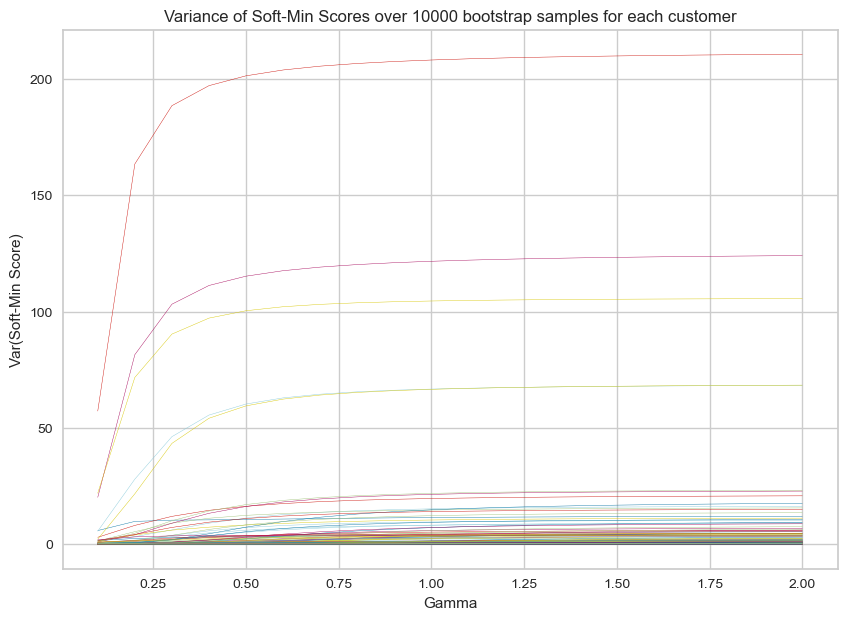

In [24]:
# calculate the spread over bootstrap dimension aka within sample variance
spread_softmin_bootstrap_scores = np.nanvar(softmin_bootstrap_scores, axis=1)

# all spreads per instances
fig = plt.figure(figsize=(10,7))
for i in range(len(softmin_bootstrap_scores)):
    plt.plot(gamma_range, spread_softmin_bootstrap_scores[i], linewidth=0.3)
    plt.xlabel("Gamma")
    plt.ylabel("Var(Soft-Min Score)")
    plt.title(f"Variance of Soft-Min Scores over {N_BOOTSTRAP} bootstrap samples for each customer")
plt.show()

In [25]:
def mean_var_of_most_anomalous(customer_variances, n_most_outliers = OUTLIERS_FRAC):
    n_most_outliers = math.ceil(len(customer_variances) * OUTLIERS_FRAC)
    var_of_outliers = np.sort(customer_variances)[::-1][:n_most_outliers]
    return np.mean(var_of_outliers)

In [26]:
bias_measures = np.apply_along_axis(score_bias_eval, 0, mean_softmin_bootstrap_scores)
var_measures = np.apply_along_axis(mean_var_of_most_anomalous, 0, spread_softmin_bootstrap_scores)
gamma_overview = pd.DataFrame(bias_measures, index=["Accuracy", "Spearman Corr", "Spearman Corr Fraction", "Spearman Corr Top 5"])
gamma_overview.loc["Model Var", :] = var_measures
gamma_overview

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Accuracy,0.659091,0.704545,0.772727,0.840909,0.863636,0.863636,0.909091,0.909091,0.909091,0.909091,0.931818,0.931818,0.931818,0.931818,0.931818,0.931818,0.954545,0.954545,0.977273,0.977273
Spearman Corr,0.677669,0.741434,0.784491,0.815821,0.838293,0.855475,0.869648,0.880865,0.890194,0.898606,0.906413,0.913829,0.919496,0.925374,0.930784,0.935839,0.940533,0.944720,0.948757,0.953118
Spearman Corr Fraction,0.096688,0.126004,0.205920,0.197886,0.290063,0.088654,0.280761,0.289359,0.204651,0.200987,0.210007,0.371670,0.388302,0.343340,0.329810,0.343622,0.412121,0.450176,0.345314,0.379140
Spearman Corr Top 5,0.100000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Model Var,3.275706,9.976302,13.376021,15.328792,16.635241,17.580078,18.286467,18.821725,19.235368,19.556170,19.808313,20.011624,20.176602,20.311460,20.422964,20.516144,20.594782,20.661755,20.719272,20.769052


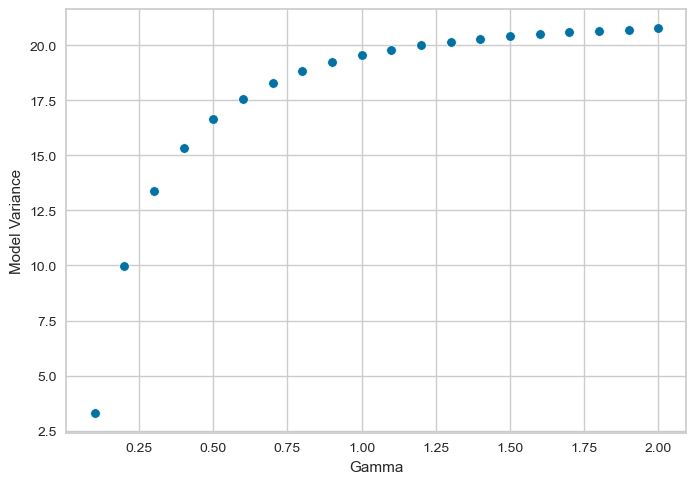

In [27]:
g = sns.scatterplot(x=gamma_range, y=var_measures)
g.set_xlabel('Gamma')
g.set_ylabel('Model Variance')
plt.show()

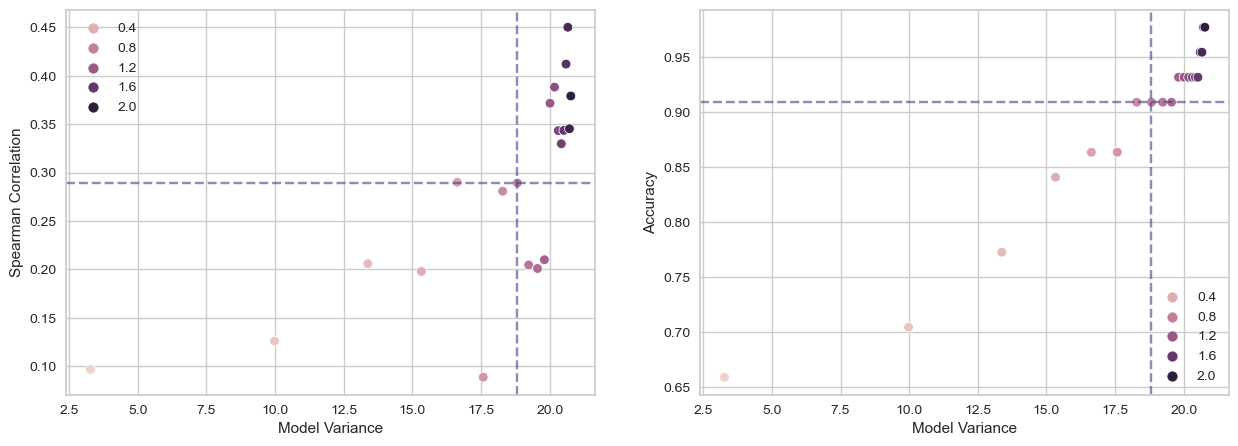

In [46]:
# Add lines for selected gamma value
filter = np.around(gamma_range, 1) == 0.8
acc = gamma_overview.loc["Accuracy"][filter]
sc = gamma_overview.loc["Spearman Corr Fraction"][filter]
var = gamma_overview.loc["Model Var"][filter]

figure, axs = plt.subplots(1,2, figsize=(15, 5))

g = sns.scatterplot(y=gamma_overview.loc["Spearman Corr Fraction", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[0])
g.axhline(y=sc.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.axvline(x=var.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.set_xlabel('Model Variance')
g.set_ylabel('Spearman Correlation')

g = sns.scatterplot(y=gamma_overview.loc["Accuracy", ], x=gamma_overview.loc["Model Var", ], hue=gamma_range, ax=axs[1])
g.axhline(y=acc.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.axvline(x=var.values, linestyle ="--", color="darkslateblue", alpha=0.6)
g.set_xlabel('Model Variance')
g.set_ylabel('Accuracy')

plt.show()

## 2.3. Outlier selection for further analyses

In [29]:
GAMMA = 0.8

nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, indices = nbrs.kneighbors(df)
distances = np.square(distances)

df_overview["softmin_score"] = np.apply_along_axis(softmin, 1, distances[:, 1:], GAMMA)
acc, spr_all, spr_fraction, spr_extreme = score_bias_eval(scores=df_overview["softmin_score"])

print(f"Accuracy: {acc:.2}% "
      f"\nSpearman corr.: {spr_all:.2}"
      f"\nSpearman corr. on the fraction of outliers: {spr_fraction:.2}"
      f"\nSpearman corr. on the top five outliers: {spr_extreme:.2}")

Accuracy: 0.91% 
Spearman corr.: 0.88
Spearman corr. on the fraction of outliers: 0.41
Spearman corr. on the top five outliers: 0.9


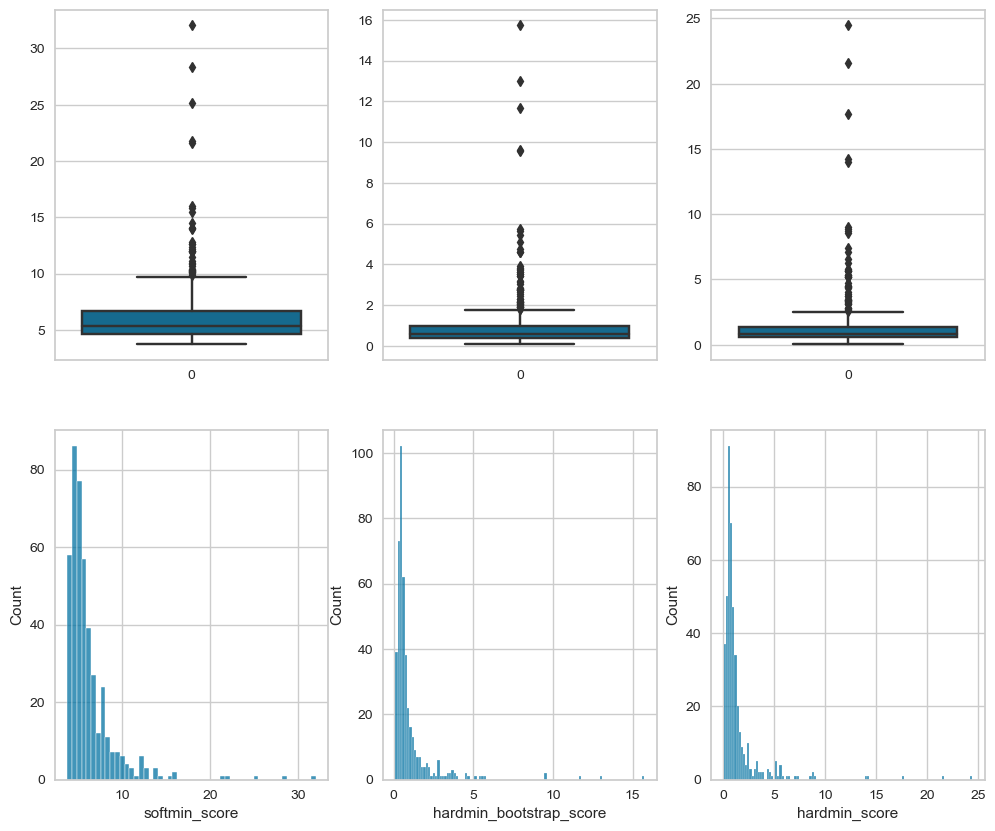

In [30]:
# Visually compare distributions of the scores
fig, axs = plt.subplots(2,3, figsize=(12,10))

sns.boxplot(df_overview["softmin_score"], ax=axs[0, 0])
sns.histplot(df_overview["softmin_score"], ax=axs[1, 0])
sns.boxplot(df_overview["hardmin_bootstrap_score"], ax=axs[0, 1])
sns.histplot(df_overview["hardmin_bootstrap_score"], ax=axs[1, 1])
sns.boxplot(df_overview["hardmin_score"], ax=axs[0, 2])
sns.histplot(df_overview["hardmin_score"], ax=axs[1, 2])
plt.show()

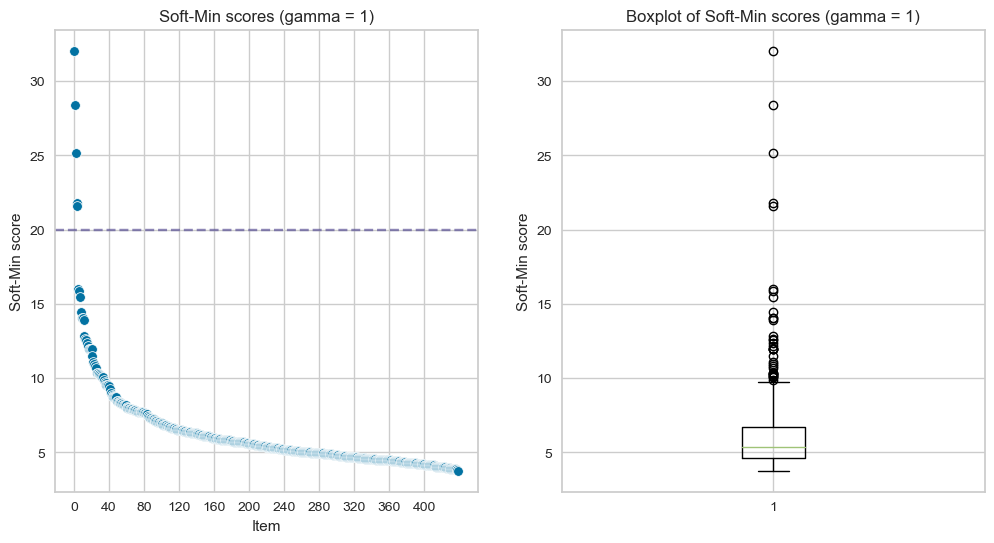

In [31]:
# The scores are already computed for gamma = 1
outliers = df_overview["softmin_score"]

threshold = 20
min, max = p1_functions.plot_outliers(outliers, "softmin", threshold)

In [32]:
for n in (threshold, 15, max):
    mask = outliers > n
    outliers_selected = outliers.argsort()[::-1][:sum(mask)]
    print(outliers_selected.shape[0], "outliers above", str(round(n, 2)))

5 outliers above 20
8 outliers above 15
35 outliers above 9.71


In [33]:
mask = outliers > threshold
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

# Display the spending of the outlier customers in the original data set
display(df_og.iloc[outliers_selected,:])

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
338,3,333,7021,15601,15,550
75,20398,1137,3,4407,3,975
154,622,55,137,75,7,8
142,37036,7152,8253,2995,20,3
95,3,2920,6252,440,223,709


# 3. Explaining Anomalies

## 3.1. Layer-wise relevance propagation

In [34]:
def relevance(x, yj, gamma):
    """
    Calculate layer-wise relevance propagation
    @x: array of instances
    @yj: softmin scores of all j instances
    @gamma: gamma used for softmin
    """
    Rji = np.zeros(x.shape)

    # calculation per instance
    for j in range(len(x)):

        # mask is used to exclude the current instance j
        mask = np.full((len(x)), True)
        mask[j] = False

        # save xk - xj
        xk_j = x - x[j]

        # calculate zk = ||xj - xk||^2
        zk = np.square(np.linalg.norm(xk_j, axis=1))

        # 1. First, one identifies to what extent each data point has contributed to the anomaly score of instance j
        temp = np.exp(-gamma * zk[mask])
        Rk = temp / np.sum(temp) * yj[j]

        # 2. Then, these scores can be propagated back to the input features by observing that the (squared)
        # Euclidean distance entering the anomaly score can be decomposed in terms of individual components:
        Rji[j, :] = np.sum(np.square(xk_j)[mask] / zk[mask][:, None] * Rk[:, None], axis=0)

    return Rji

In [35]:
# Calculate anomaly scores
nbrs = NearestNeighbors(n_neighbors=len(df), algorithm="ball_tree").fit(df)
distances, _ = nbrs.kneighbors(df)
yj = np.apply_along_axis(softmin, 1, np.square(distances[:, 1:]), GAMMA)

x = df.to_numpy()
Rji = relevance(x, yj, GAMMA)

# confirm conservation property
np.all(np.sum(Rji, axis=1) - yj <= 1e-14)

True

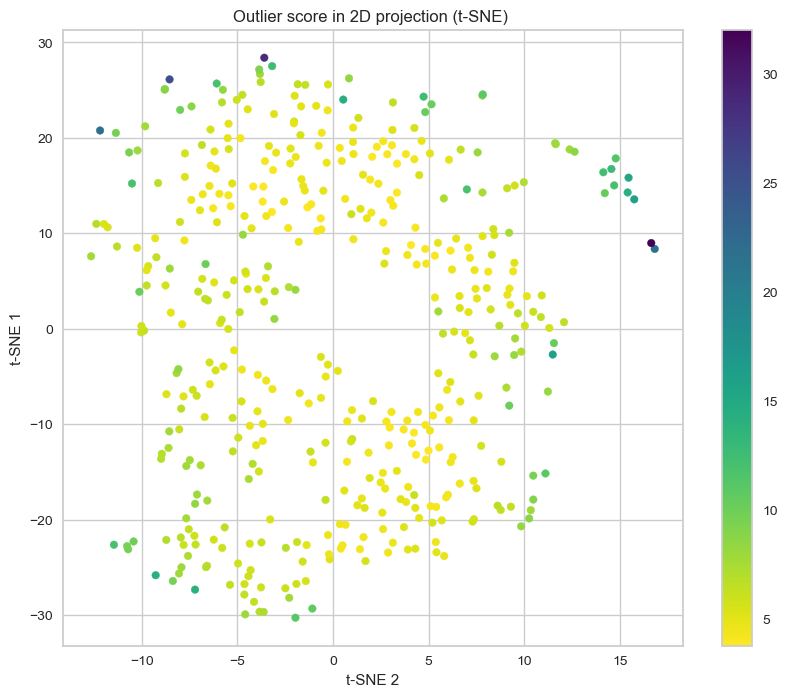

In [36]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30).fit_transform(df)

f, ax = plt.subplots(figsize=(10,8))
points = ax.scatter(x=X_embedded[:,1], y=X_embedded[:,0], c=yj, s=30, cmap=plt.colormaps.get_cmap('viridis_r'))
f.colorbar(points)
ax.set_ylabel("t-SNE 1")
ax.set_xlabel("t-SNE 2")
ax.set_title("Outlier score in 2D projection (t-SNE) ")
plt.show()

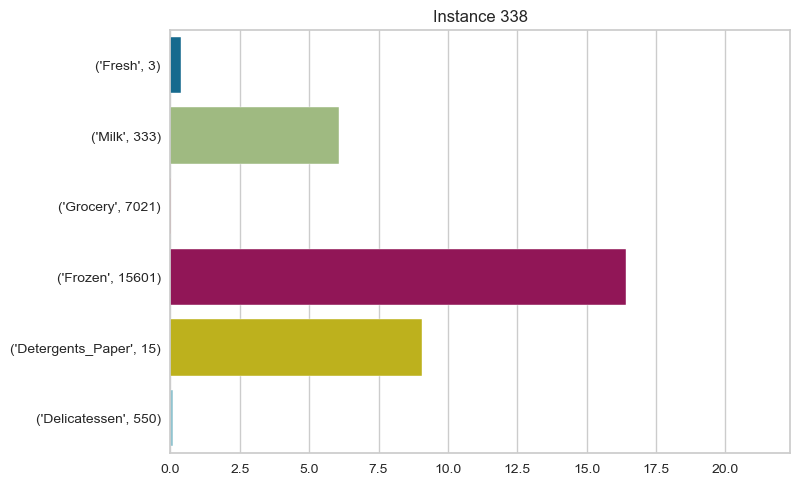

Ri: [ 0.38073448  6.07619614  0.01907647 16.40797732  9.05480296  0.10190989]
Outlier score: 32.04069725635833


Fresh                   3
Milk                  333
Grocery              7021
Frozen              15601
Detergents_Paper       15
Delicatessen          550
Name: 338, dtype: int64

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440,440,440,440,440,440
mean,12000,5796,7951,3072,2881,1525
std,12647,7380,9503,4855,4768,2820
min,3,55,3,25,3,3
25%,3128,1533,2153,742,257,408
50%,8504,3627,4756,1526,816,966
75%,16934,7190,10656,3554,3922,1820
max,112151,73498,92780,60869,40827,47943


In [37]:
instance = 338
g = sns.barplot(x=Rji[instance], y=list(map(str, list(zip(df_og.iloc[instance].index, df_og.iloc[instance].values)))))
g.set_xlim(0,np.max(Rji))
g.set_title("Instance " + str(instance))
plt.show()

print("Ri:", Rji[instance])
print("Outlier score:", yj[instance])

# Display the spending of the outlier customers in the original data set
display(df_og.iloc[instance])

# Display the original data stats
df_og.describe().applymap(lambda x: f"{x:0.0f}")

## 3.2. Robustness of the explanations

In [97]:
# Smooth Bootstrapping with replacement (relevance calculation only works in case of no 0-distances)
# for each gamma:
#   calculate anomaly scores for sample instances
#   calculate relevance
#   save relevance (per component) for later analysis

N_BOOTSTRAP = 1000
gamma_range = np.linspace(0.1, 2, 20)

Rji_BS = np.full((len(df_og), N_BOOTSTRAP, len(gamma_range), 6), np.nan)

for i in range(N_BOOTSTRAP):
    sample = samples[i]

    # ver 2) Add Gaussian noise
    m = 0  # Mean of the Gaussian noise
    std = 0.01  # Standard deviation of the Gaussian noise
    noise = np.random.normal(loc=m, scale=std, size=sample.shape)
    sample = sample + noise
    #Clip values at zero
    sample = sample.clip(lower=0)

    nbrs = NearestNeighbors(n_neighbors=len(sample), algorithm="ball_tree").fit(sample)
    distances, _ = nbrs.kneighbors(sample)
    distances = np.square(distances[:, 1:])

    for k, g in enumerate(gamma_range):
        yj = np.apply_along_axis(softmin, 1, distances, g)
        Rji_BS[sample.index, i, k, :] = relevance(sample.to_numpy(), yj, g)

# for each instance, for each sample, for each gamma, the relevance per component
Rji_BS.shape

(440, 1000, 20, 6)


(440, 1000, 20, 6)

#### Component-wise computations

For each item we calculate statistics of the anomaly attribution scores over each bootstrap sample. We compute this measure for all gammas. The statistics include mean, variance, and standard deviation. We plot the values of the anomaly attribution mean and then variance per feature against the gamma values and mark the outliers in blue.

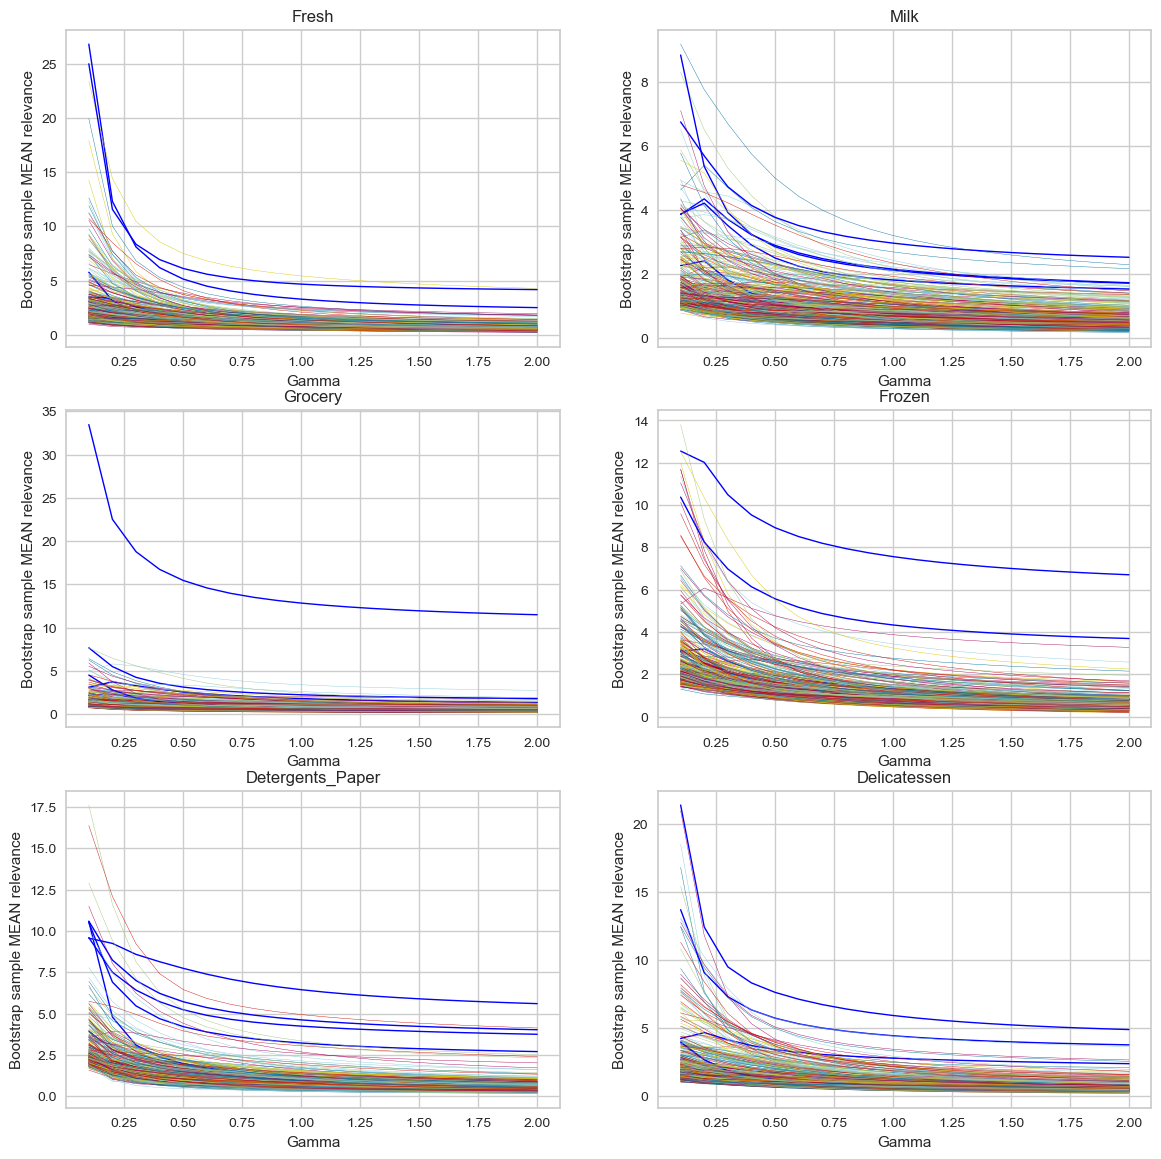

In [104]:
# Get the statistics over bootstraps
bootstrap_mean = np.nanmean(Rji_BS, axis=1) # all items mean over the boostraps for all gammas for all features
bootstrap_variance = np.nanvar(Rji_BS, axis=1) # all items variance over the boostraps for all gammas for all features
bootstrap_std = np.nanstd(Rji_BS, axis=1) # all items std over the boostraps for all gammas for all features

p1_functions.attribution_stat_plots(bootstrap_mean, gamma_range, num_features, outliers_selected.array, type = "MEAN")

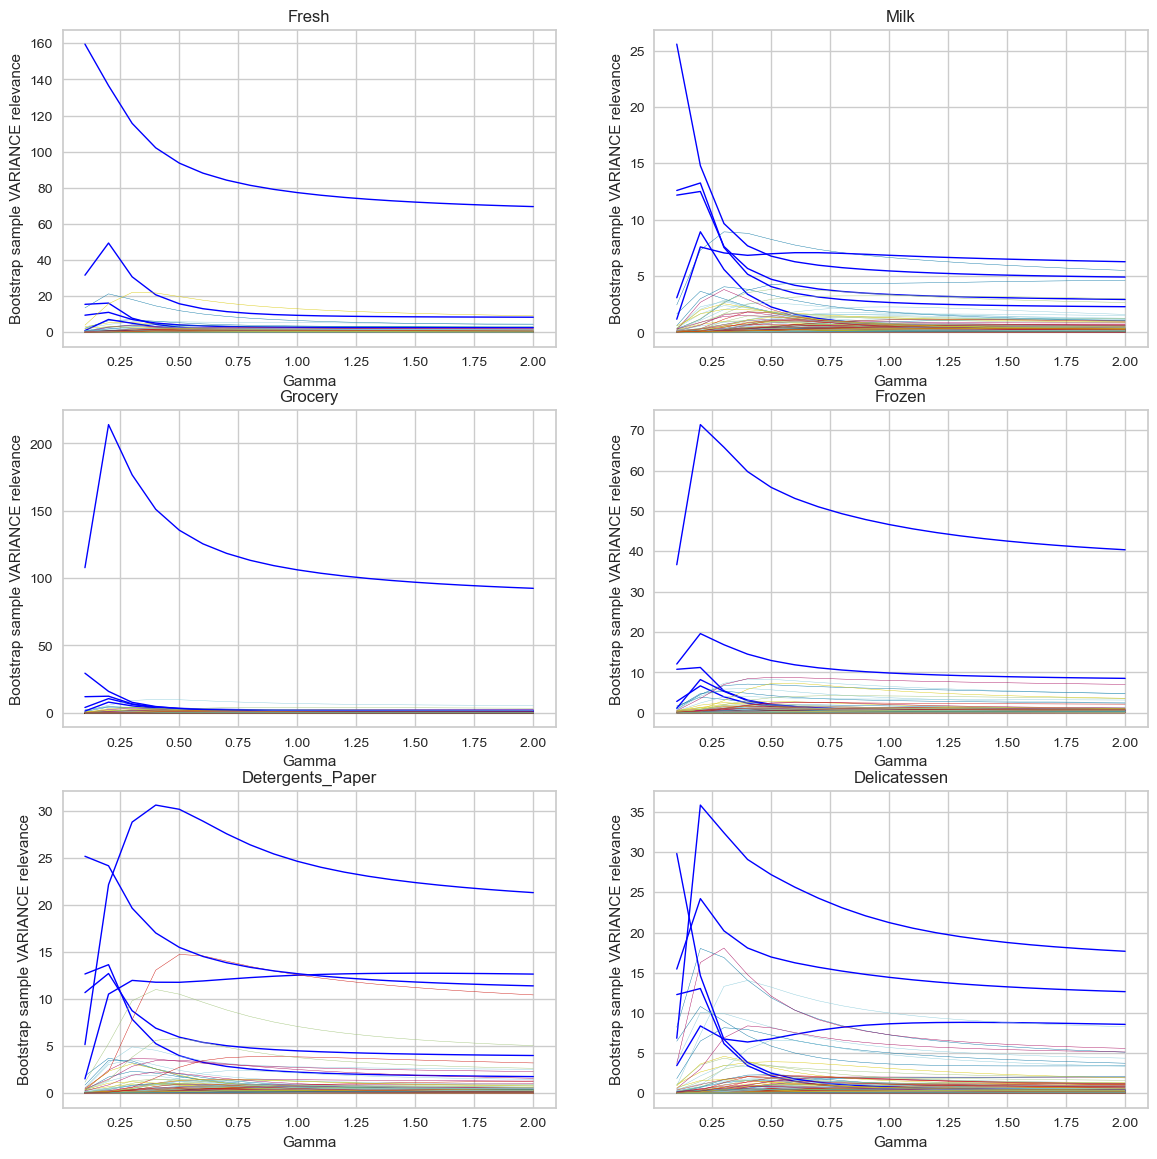

In [105]:
p1_functions.attribution_stat_plots(bootstrap_variance, gamma_range, num_features, outliers_selected.array, type = "VARIANCE")

#### Feature-wise computations
We also computed the mean values of attribution variance for each feature. We plot these computations separately for inliers (all points but outliers) and outliers (all points but outliers) and outliers (for this application, extreme values defined by a boxplot stats).

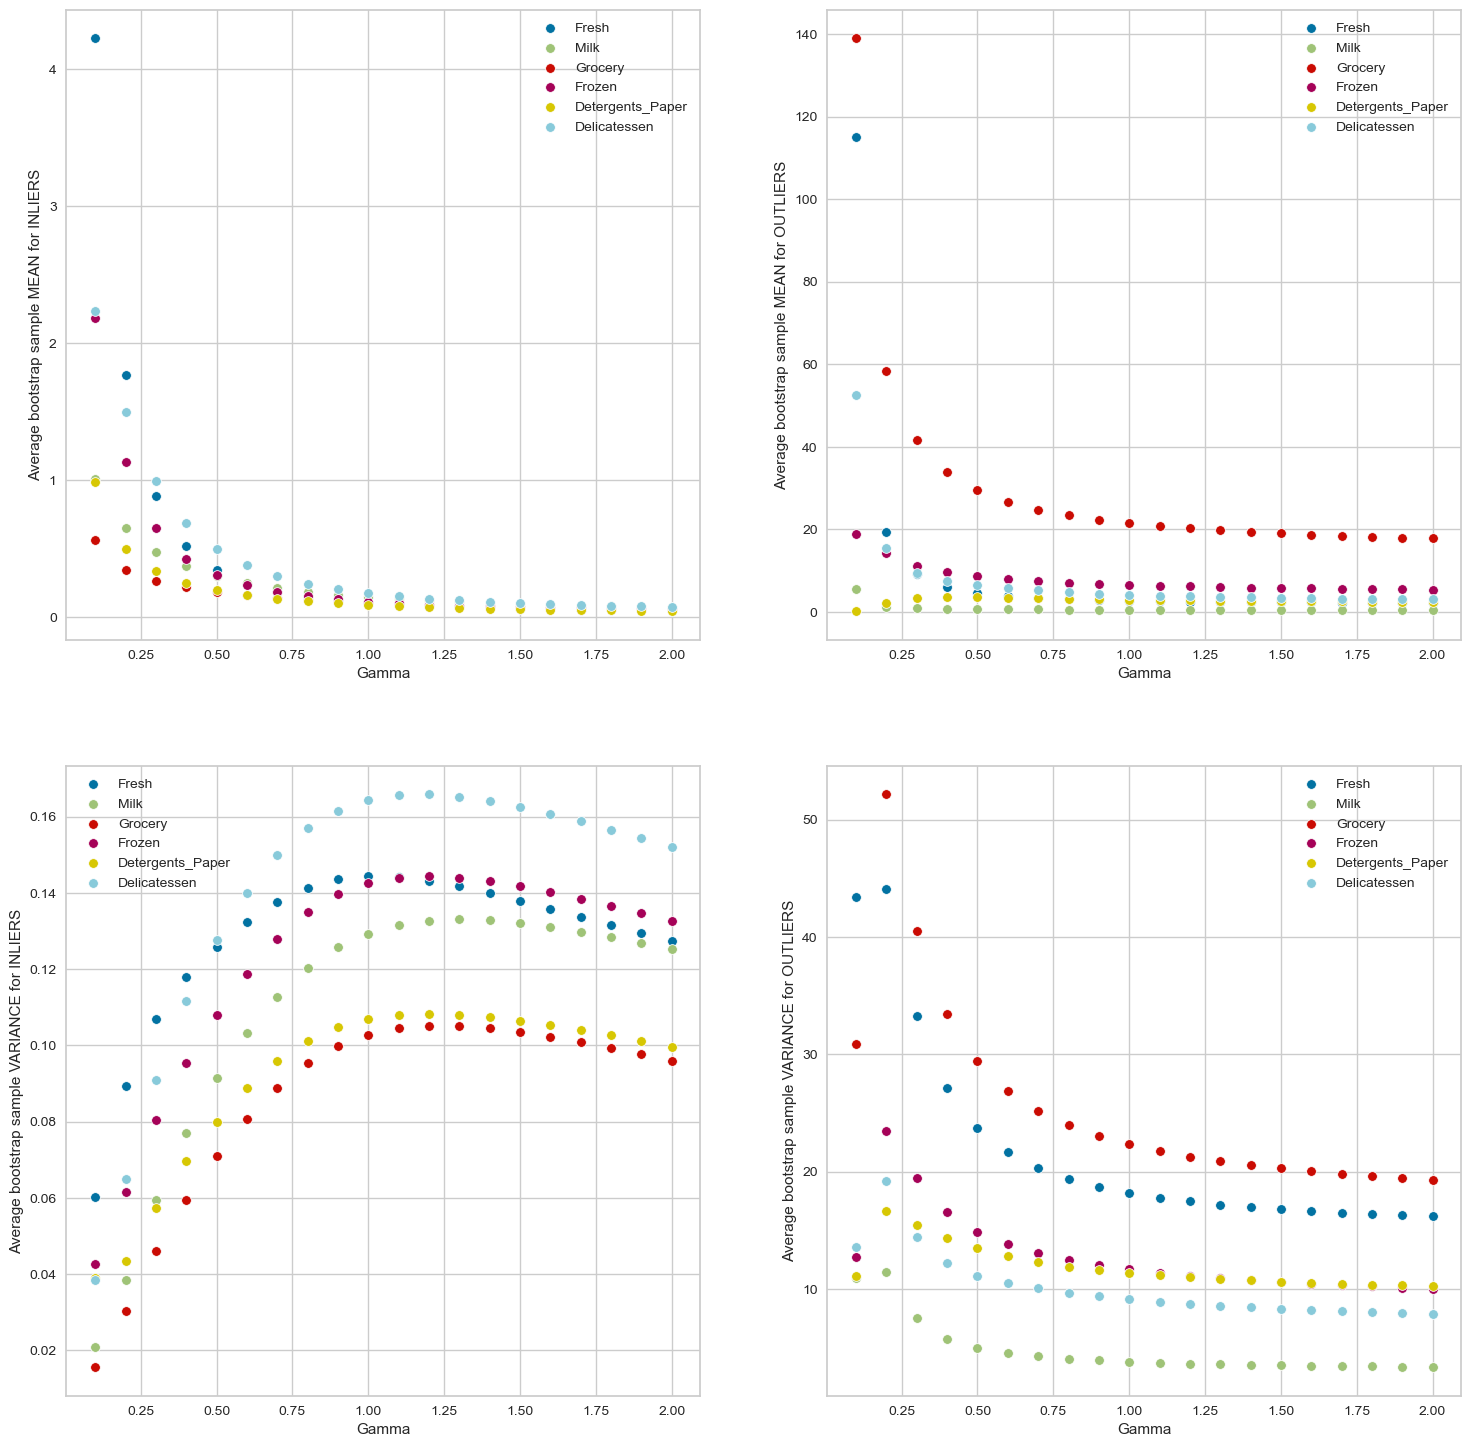

In [106]:
# Get the index if gamma = 1 from the experiment
gamma_index = np.argwhere(np.around(gamma_range, 1) == 0.8)[0,0]

# Get the statistics over bootstraps for gamma = 1
bootstrap_mean_g = pd.DataFrame(bootstrap_mean[:,gamma_index,:], columns = num_features)
bootstrap_var_g = pd.DataFrame(bootstrap_variance[:,gamma_index,:], columns = num_features)

# Mean values of attribution variance for each feature.
# We plot these computations separately for inliers
mask = outliers <= max
inliers = outliers.argsort()[:sum(mask)]

p1_functions.attribution_variance_means(bootstrap_mean, bootstrap_variance, gamma_range, num_features, outliers_selected.array, inliers)

#### Biasedness of the explanations
We want to inspect the biasedness of the estimated relevance of each component by the Bootstrap experiment. For this, we use the relevance attribution scores computed for the whole dataset and compute Spearman ranking correlation.

In [101]:
# Compare the "ground truth" attribution scores with the boostrap sample means
for i, feature in enumerate(num_features):
    corr, _ = spearmanr(Rji[:,i], bootstrap_mean_g.iloc[:,i])
    corr_outliers, _ = spearmanr(Rji[outliers_selected,i], bootstrap_mean_g.iloc[outliers_selected,i])
    print(f"{feature}: all data: {corr:.2} \n       outliers: {corr_outliers:.2}")

Fresh: all data: 0.95 
       outliers: 0.7
Milk: all data: 0.96 
       outliers: 1.0
Grocery: all data: 0.91 
       outliers: 0.9
Frozen: all data: 0.98 
       outliers: 0.9
Detergents_Paper: all data: 0.96 
       outliers: 0.9
Delicatessen: all data: 0.98 
       outliers: 0.9


# 4. Cluster Analysis

## 4.1. K parameter for K-means

In [38]:
# Remove the selected outlier points
outliers = df_overview["softmin_score"]
mask = outliers > threshold
outliers_selected = outliers.argsort()[::-1][:sum(mask)]

df = df.drop(labels=outliers_selected, axis=0)

Compute visualisation to identify the optimal inflection point for K in [2, 15]:
* elbow (distortion score): the sum of squared distances from each point to its assigned center:
* silhouette score: the mean Silhouette Coefficient of all samples;
* Calinski-Harabasz score: the ratio of dispersion between and within clusters.

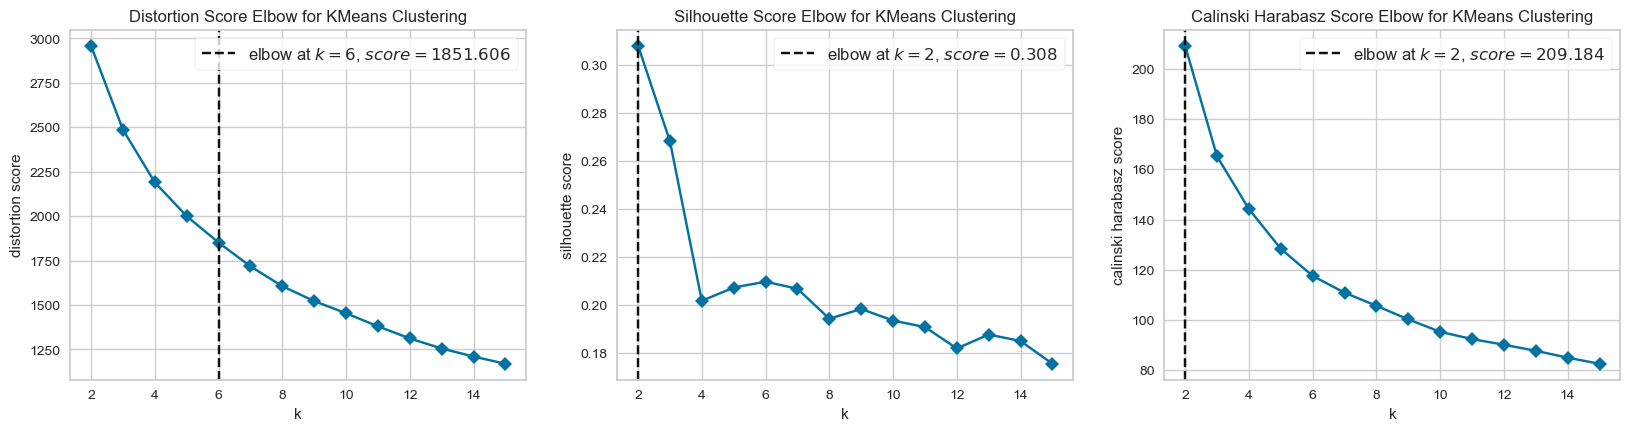

In [40]:
# K-means initialised with greedy k-means++ algorithm, over 100 initialisations
kmeans = KMeans(init="k-means++", n_init=100, random_state=42)

fig = plt.figure(figsize=(20,10))
gs = gridspec.GridSpec(2,3)
ax = {}

for i, metr in zip(range(3), ['distortion', 'silhouette', 'calinski_harabasz']):
    ax[i] = fig.add_subplot(gs[i])
    ax[i] = visualizer = KElbowVisualizer(kmeans, k=(2,16), metric=metr, timings=False, show=True)
    visualizer.fit(df)
    visualizer.finalize()

plt.show()

Observation:

There is no clear infliction point in the elbow plot of the distoriotn score, we can assume K = 5 or K = 6 to be a reasonable trade-off point. Similar result is obtained by computing the Calinski-Harabasz index.
The silhouette score is strongly reduced for K > 3, however we assume that more than three clusters is reasonable in order to partition the customers in this application.

#### In addition we perform K-means clustering for K in the range [5, 6] and inspect the silhouette plots for the clusters.

For n_clusters = 5 The average silhouette_score is : 0.20699326941113105
For n_clusters = 6 The average silhouette_score is : 0.21196221086019812


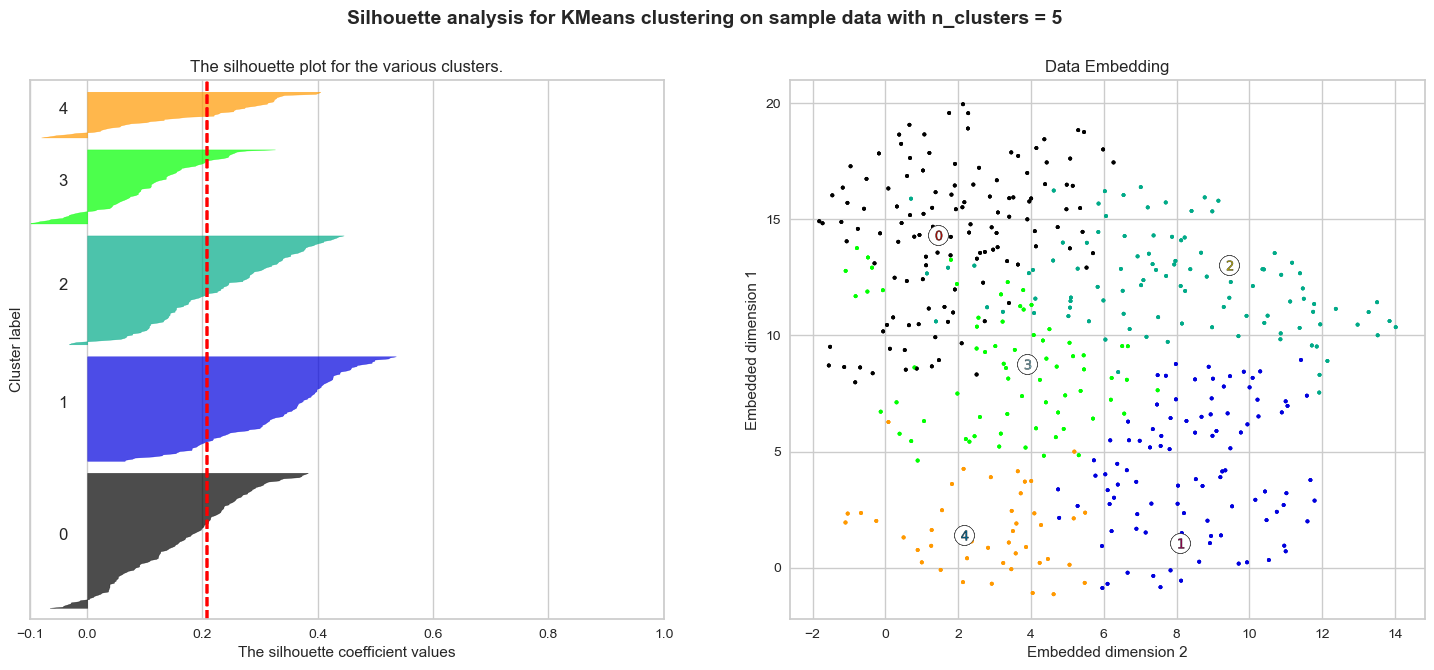

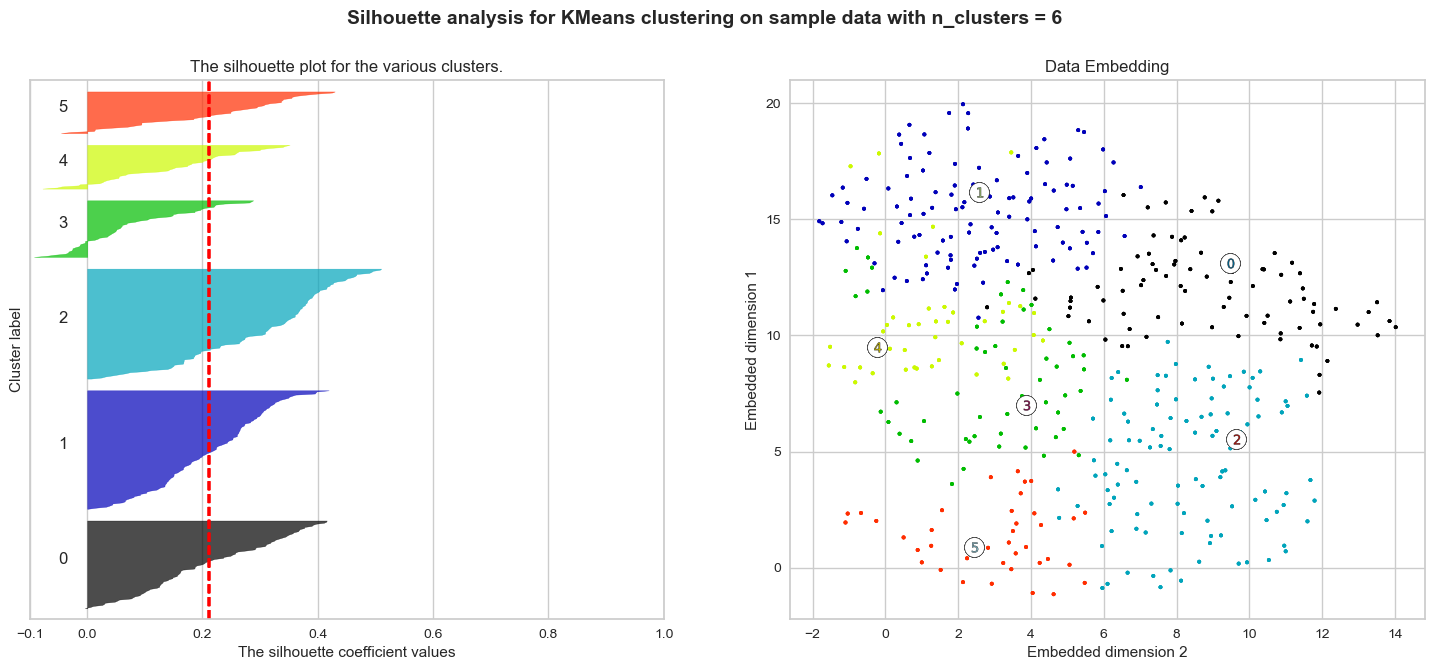

In [41]:
p1_functions.silhouette_analysis(min_k=5, max_k=6, X=df, Umap=True)

## 4.2. Clustering

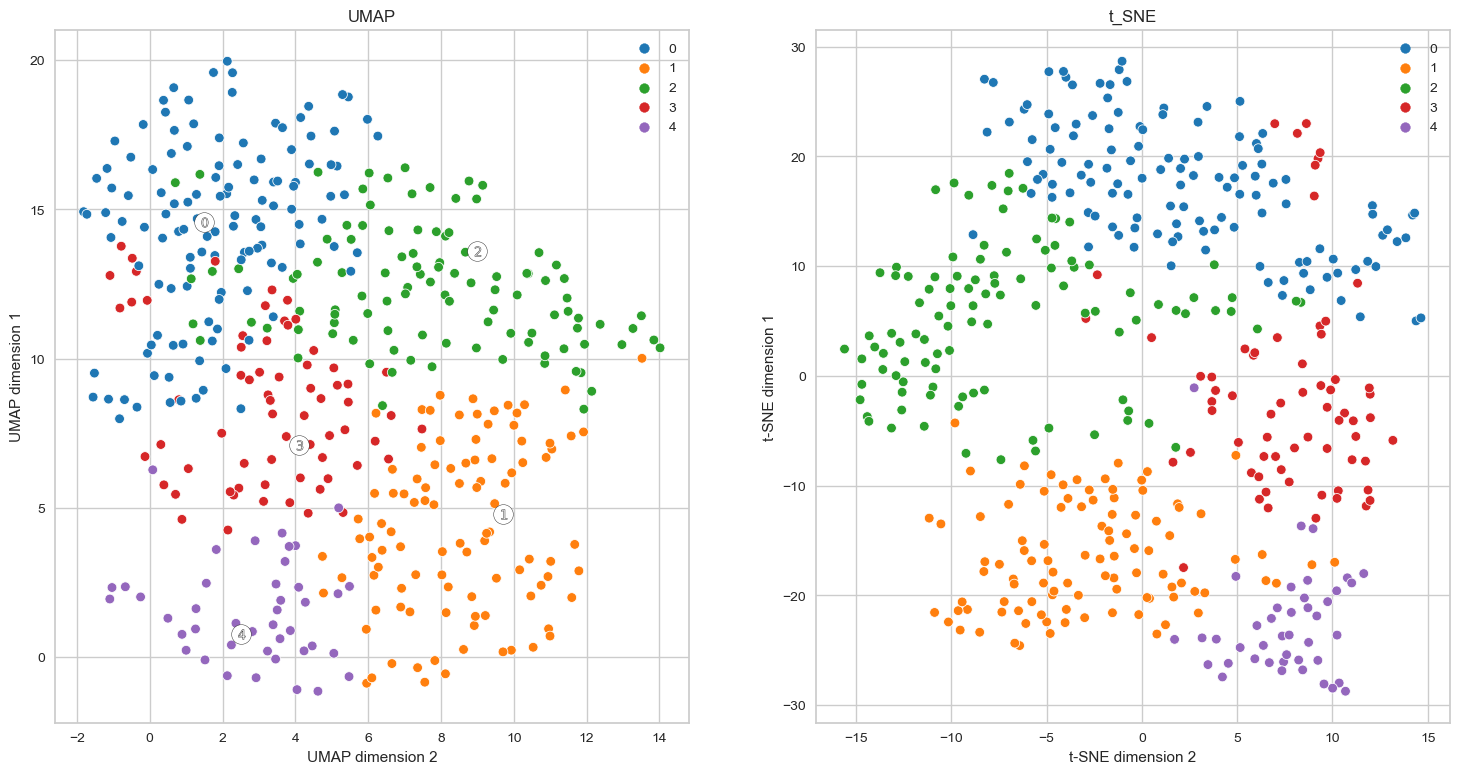

In [53]:
# Fit k-Means and visualise using UMAP and t-SNE
K = 5
kmeans = KMeans(n_clusters=K, init="k-means++", n_init=100, random_state=42).fit(df)
p1_functions.visualise_kmeans(df, kmeans)

In [50]:
print("k-Means cluster sizes:")
for cluster in set(kmeans.labels_):
    filter = kmeans.labels_ == cluster
    print("Cluster:", cluster, ":", sum(kmeans.labels_ == cluster))

k-Means cluster sizes:
Cluster: 0 : 123
Cluster: 1 : 100
Cluster: 2 : 104
Cluster: 3 : 66
Cluster: 4 : 42


## 4.3. Interpretation of the clustering

For an interpretation of the clustering, we plot average spending of cluster members for the different product categories.
We computed means and standard deviations for each category within each cluster, as well as boxplots for each clsuter within each category.

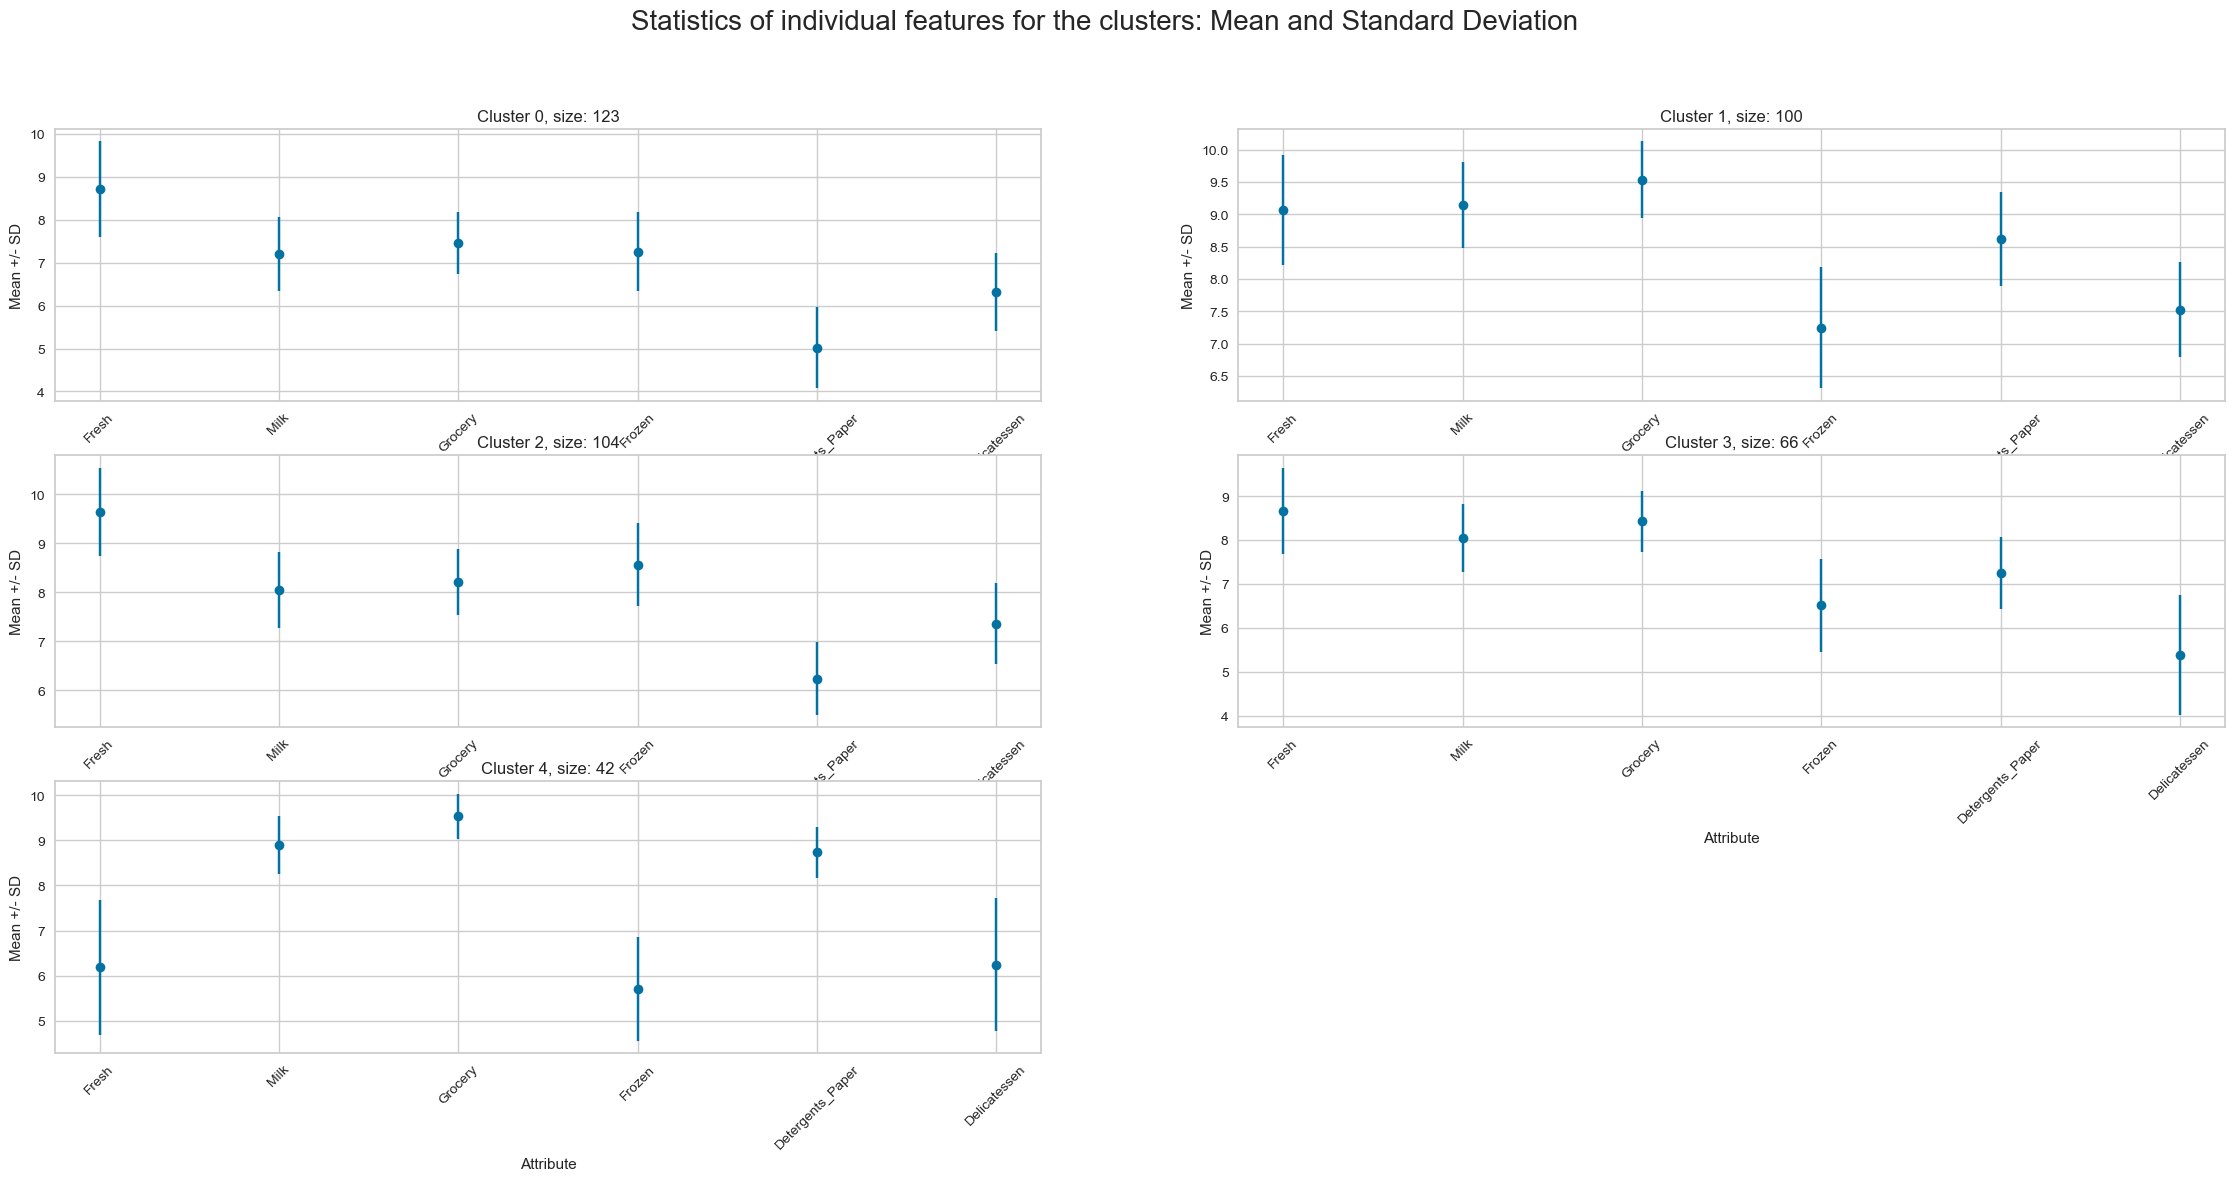

ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of labels (6).

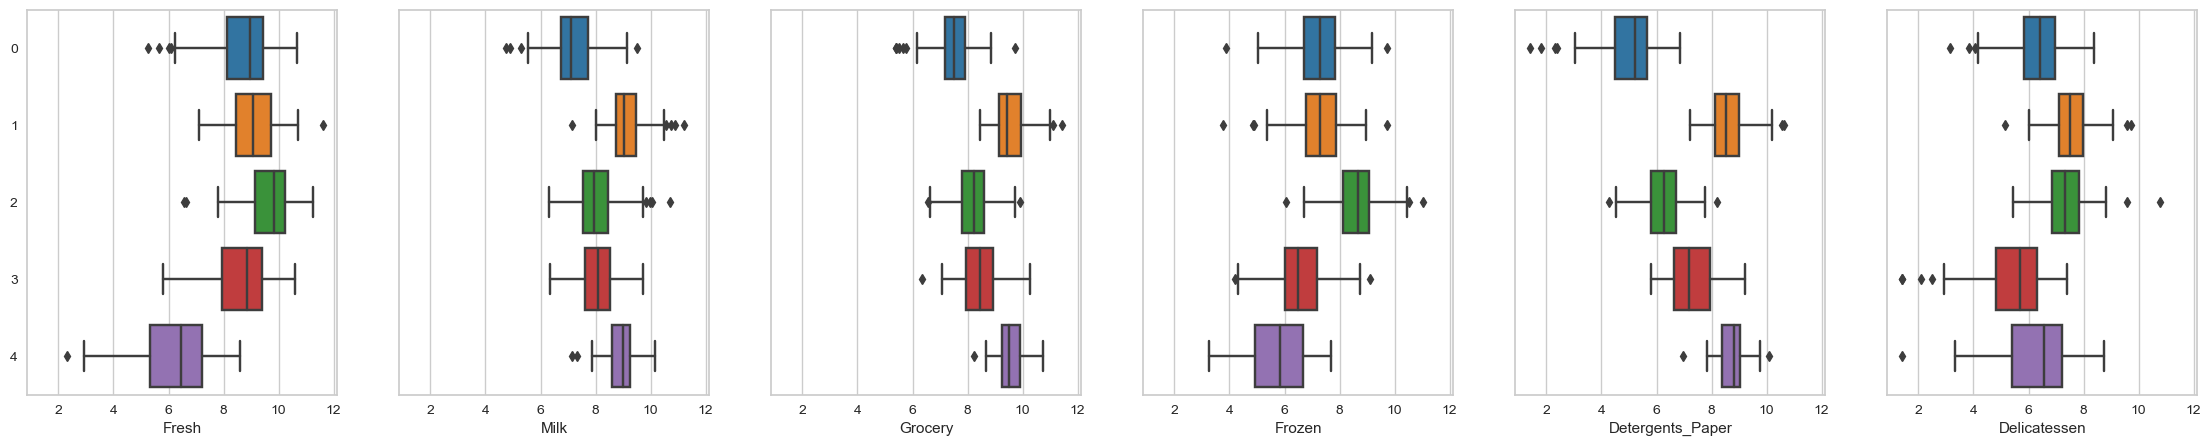

In [51]:
p1_functions.clusters_stats(df, kmeans)